# Дипломный проект. Часть 1:  EDA

# I. Импорт библиотек

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import altair as alt

import warnings
warnings.filterwarnings("ignore")

In [274]:
def stationarity_test(data, timeframe):
# Протестируем стационарность ряда при помощи теста Дикки-Фуллера
  data_output = data[-timeframe:-1]
  test = sm.tsa.adfuller(data_output.values.flatten())
  print ('p-value: ', test[1])
  if test[1]< 0.05: 
    print ('data is stationary')
  else:
    print ('there is a trend')

def select_start(data, timeframe):
  data_output = data[-timeframe:-1]
  return data_output


def visualize_trend(data, period, timeframe):
  decomposition = seasonal_decompose(select_start(data, timeframe), model='additive',period=period) 
  plt.figure(figsize = (17,8))
  decomposition.plot()
  plt.show() 

  stationarity_test(data, timeframe)

# II. Данные

In [275]:
df_village = pd.read_csv('village.csv')

### Описание полей
village           - деревня покупателя  
year              - год продажи  
parent_customer   - семья, которая делает покупки  
category          - категория товаров  
fruit             - вид фрукта  
grade             - сорт фрукта  
order_date        - дата заказа  
delivery_date     - дата поставки   
ordered           - количество заказа  
shipped           - фактически огружено  

# III. EDA

## 1. Пропуски

In [276]:
# Посмотрим на количество записей
df_village.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246891 entries, 0 to 246890
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   village        246891 non-null  object 
 1   year           246891 non-null  int64  
 2   family         246891 non-null  object 
 3   category       246891 non-null  object 
 4   fruit          246891 non-null  object 
 5   grade          246891 non-null  int64  
 6   order_date     246891 non-null  object 
 7   delivery_date  246509 non-null  object 
 8   ordered        246869 non-null  float64
 9   shipped        246198 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 18.8+ MB


Присутствуют пропуски в полях даты отгрузки, заказанного и огруженного количества. Посмотрим подробнее

#### 1.1. Delivery Date

In [277]:
df_village[df_village.delivery_date.isna() == True]

village  year     family      category       fruit  grade  \
664     Robinhood_village  2020  family_17   category_14    fruit_58    333   
791     Robinhood_village  2020  family_23   category_56   fruit_376    166   
3112    Robinhood_village  2020  family_82   category_16   fruit_392    333   
5960    Robinhood_village  2020  family_11   category_60   fruit_650    199   
6886    Robinhood_village  2020  family_70  category_102  fruit_1426    330   
...                   ...   ...        ...           ...         ...    ...   
239846  Robinhood_village  2022   family_4   category_76  fruit_4341    333   
244719  Robinhood_village  2020  family_84    category_9  fruit_4500    333   
244735  Robinhood_village  2020  family_84   category_24   fruit_328    330   
244763  Robinhood_village  2020  family_84   category_24   fruit_328    330   
244771  Robinhood_village  2020  family_84    category_9  fruit_4500    333   

        order_date delivery_date  ordered  shipped  
664     2020-01-07           NaN     12.0   11.387  
791     2020-01-07           NaN     24.0   21.333  
3112    2020-01-13           NaN      2.0    1.833  
5960    2020-01-20           NaN     75.0   60.850  
6886    2020-01-22           NaN     10.0    6.400  
...            ...           ...      ...      ...  
239846  2022-02-07           NaN      3.6    3.058  
244719  2020-03-30           NaN      4.0    3.772  
244735  2020-04-02           NaN     40.0   27.083  
244763  2020-04-16           NaN     20.0   16.667  
244771  2020-04-20           NaN      6.0    5.507  

[382 rows x 10 columns]

Пропуски в дате поставки отсутствуют также у выбранных клиентов

In [278]:
# Преобразуем в формат datetime
df_village.order_date = pd.to_datetime(df_village.order_date)
df_village.delivery_date = pd.to_datetime(df_village.delivery_date)

Дата поставки может быть важным элементом анализа, поэтому имеет смысл заменить пропуски на среднее значение сроков реализации данного продукта в месяце, когда был сделан заказ. Для этого имеет смысл создать новый признак leadtime.

In [279]:
df_village['leadtime'] = df_village.delivery_date - df_village.order_date

In [280]:
# df_village

In [281]:
df_village.leadtime.value_counts()

7 days      37824
6 days      34143
8 days      20276
4 days      15658
5 days      11333
            ...  
228 days        1
176 days        1
157 days        1
242 days        1
163 days        1
Name: leadtime, Length: 197, dtype: int64

Сроки поставок в 2020 году

In [282]:
df_2020 = df_village.query('year == 2020')
df_2020.leadtime.value_counts()

6 days      18495
7 days      17820
8 days       9596
4 days       8175
5 days       6186
            ...  
263 days        1
374 days        1
218 days        1
88 days         1
228 days        1
Name: leadtime, Length: 163, dtype: int64

In [283]:
df_2020.leadtime.mean()

Timedelta('10 days 08:23:25.928424891')

In [284]:
df_2020.leadtime.median()

Timedelta('7 days 00:00:00')

Сроки поставок в 2021 году

In [285]:
df_2021 = df_village.query('year == 2021')
df_2021.leadtime.value_counts()

7 days      18160
6 days      14387
8 days       9731
4 days       6957
5 days       5037
            ...  
135 days        1
161 days        1
153 days        1
164 days        1
162 days        1
Name: leadtime, Length: 171, dtype: int64

In [286]:
df_2021.leadtime.mean()

Timedelta('14 days 10:17:06.949795536')

In [287]:
df_2021.leadtime.median()

Timedelta('8 days 00:00:00')

Сроки поставок в 2022 году

In [288]:
df_2022 = df_village.query('year == 2022')
df_2022.leadtime.value_counts()

7 days      1844
6 days      1261
8 days       949
4 days       526
36 days      334
            ... 
81 days        1
83 days        1
88 days        1
141 days       1
102 days       1
Name: leadtime, Length: 86, dtype: int64

In [289]:
df_2022.leadtime.mean()

Timedelta('23 days 19:05:37.709274515')

In [290]:
df_2022.leadtime.median()

Timedelta('20 days 00:00:00')

In [291]:
def fillleadtime(data):
    data_20 = data.query('year == 2020')
    data_21 = data.query('year == 2021')
    data_22 = data.query('year == 2022')
    
    if [data['year'] == 2020]:
        data['leadtime'].fillna(data_20['leadtime'].median(), inplace=True)
    elif [data.year == 2021]:
        data['leadtime'].fillna(data_21['leadtime'].median(), inplace=True)
    elif [data.year == 2022]:
        data['leadtime'].fillna(data_22['leadtime'].median(), inplace=True)

In [292]:
fillleadtime(df_village)

In [293]:
df_village[df_village.leadtime.isna() == True]

Empty DataFrame
Columns: [village, year, family, category, fruit, grade, order_date, delivery_date, ordered, shipped, leadtime]
Index: []

In [294]:
df_village['delivery_date'].fillna(df_village.order_date + df_village.leadtime, inplace=True)

In [295]:
df_village[df_village.delivery_date.isna() == True]

Empty DataFrame
Columns: [village, year, family, category, fruit, grade, order_date, delivery_date, ordered, shipped, leadtime]
Index: []

In [296]:
df_village.order_date.max()

Timestamp('2022-03-24 00:00:00')

In [297]:
df_village.delivery_date.max()

Timestamp('2022-07-27 00:00:00')

In [298]:
df_village = df_village.sort_values(by='delivery_date', ascending=True)

In [299]:
# df_village

#### 1.2. Shipped and Ordered

In [300]:
df_village[df_village.shipped.isna() == True]

village  year      family     category       fruit  grade  \
11938   Robinhood_village  2020   family_23   category_9   fruit_311    390   
30813   Robinhood_village  2020  family_166  category_62  fruit_2339    250   
62727   Robinhood_village  2020   family_23  category_84  fruit_1365    275   
62728   Robinhood_village  2020   family_23  category_84  fruit_1365    345   
143748  Robinhood_village  2021  family_130  category_62   fruit_253    220   
...                   ...   ...         ...          ...         ...    ...   
240656  Robinhood_village  2022  family_120   category_9    fruit_32    290   
240655  Robinhood_village  2022  family_120   category_9    fruit_32    250   
242344  Robinhood_village  2022   family_27  category_87  fruit_1117    240   
231476  Robinhood_village  2022   family_19   category_9    fruit_59    285   
243235  Robinhood_village  2022   family_83  category_16  fruit_4408    333   

       order_date delivery_date  ordered  shipped leadtime  
11938  2020-02-04    2020-02-11   3900.0      NaN   7 days  
30813  2020-03-27    2020-06-23   2000.0      NaN  88 days  
62727  2020-07-30    2020-08-21   2475.0      NaN  22 days  
62728  2020-07-30    2020-08-21  15525.0      NaN  22 days  
143748 2021-04-06    2021-04-13      NaN      NaN   7 days  
...           ...           ...      ...      ...      ...  
240656 2022-02-11    2022-04-04   1160.0      NaN  52 days  
240655 2022-02-11    2022-04-04   1500.0      NaN  52 days  
242344 2022-02-28    2022-05-20   1440.0      NaN  81 days  
231476 2022-01-11    2022-05-20   2280.0      NaN 129 days  
243235 2022-03-08    2022-07-27   3996.0      NaN 141 days  

[693 rows x 11 columns]

In [301]:
df_village.head()

village  year      family     category     fruit  grade  \
7    Robinhood_village  2020  family_244  category_25  fruit_37    165   
8    Robinhood_village  2020  family_244  category_16  fruit_38    220   
12   Robinhood_village  2020  family_244  category_27  fruit_41    190   
274  Robinhood_village  2020   family_72   category_9  fruit_59    360   
514  Robinhood_village  2020   family_27  category_16  fruit_55    400   

    order_date delivery_date  ordered  shipped leadtime  
7   2019-12-30    2020-01-03   1650.0  1663.20   4 days  
8   2019-12-30    2020-01-03   2200.0  2354.00   4 days  
12  2019-12-30    2020-01-03   3800.0  3845.60   4 days  
274 2020-01-02    2020-01-07   2160.0  2191.32   5 days  
514 2020-01-03    2020-01-07   2564.0  2564.00   4 days

База данных была собрана по заказам со статусом "огружено". Пропуски в shipped -  это результат технической ошибки во время скачивания базы данных. Оптимальным вариантов замены пропусков будет присвоить пропускам значения заказов. В результате ошибка будет только погрешность во время реализации заказа.

In [302]:
df_village['shipped'].fillna(df_village['ordered'], inplace=True)

In [303]:
# У нас остаются строки, в которых нет данных о заказанном количестве
df_village[df_village.shipped.isna() == True]

village  year      family      category       fruit  grade  \
143748  Robinhood_village  2021  family_130   category_62   fruit_253    220   
146671  Robinhood_village  2021   family_33    category_9   fruit_154    250   
147730  Robinhood_village  2021   family_92   category_70  fruit_1285   1000   
148609  Robinhood_village  2021   family_23   category_10    fruit_13    350   
148871  Robinhood_village  2021   family_27   category_62  fruit_1399    250   
148758  Robinhood_village  2021   family_23   category_56   fruit_172    455   
154610  Robinhood_village  2021   family_23   category_45   fruit_316    375   
154728  Robinhood_village  2021   family_33   category_62   fruit_286    286   
156087  Robinhood_village  2021   family_11   category_47  fruit_3209    250   
157867  Robinhood_village  2021  family_315    category_9   fruit_578    200   
157873  Robinhood_village  2021  family_211   category_84   fruit_315    375   
158642  Robinhood_village  2021    family_1   category_37   fruit_123    333   
158601  Robinhood_village  2021   family_23  category_126   fruit_822    250   
159231  Robinhood_village  2021  family_174    category_9   fruit_124    250   
160890  Robinhood_village  2021  family_166   category_62  fruit_2339    250   
162859  Robinhood_village  2021   family_23   category_76  fruit_3005    250   
164522  Robinhood_village  2021   family_66   category_10   fruit_651    333   
165658  Robinhood_village  2021  family_100   category_62  fruit_2085    200   
165660  Robinhood_village  2021  family_100   category_62  fruit_2926    200   
166021  Robinhood_village  2021   family_40    category_9  fruit_3717    260   
176235  Robinhood_village  2021   family_96   category_80   fruit_937    200   

       order_date delivery_date  ordered  shipped leadtime  
143748 2021-04-06    2021-04-13      NaN      NaN   7 days  
146671 2021-04-14    2021-04-21      NaN      NaN   7 days  
147730 2021-04-17    2021-04-24      NaN      NaN   7 days  
148609 2021-04-20    2021-04-27      NaN      NaN   7 days  
148871 2021-04-21    2021-04-28      NaN      NaN   7 days  
148758 2021-04-21    2021-04-28      NaN      NaN   7 days  
154610 2021-05-06    2021-05-13      NaN      NaN   7 days  
154728 2021-05-07    2021-05-14      NaN      NaN   7 days  
156087 2021-05-12    2021-05-19      NaN      NaN   7 days  
157867 2021-05-17    2021-05-24      NaN      NaN   7 days  
157873 2021-05-17    2021-05-24      NaN      NaN   7 days  
158642 2021-05-18    2021-05-25      NaN      NaN   7 days  
158601 2021-05-18    2021-05-25      NaN      NaN   7 days  
159231 2021-05-20    2021-05-27      NaN      NaN   7 days  
160890 2021-05-25    2021-06-01      NaN      NaN   7 days  
162859 2021-05-31    2021-06-07      NaN      NaN   7 days  
164522 2021-06-07    2021-06-14      NaN      NaN   7 days  
165658 2021-06-09    2021-06-16      NaN      NaN   7 days  
165660 2021-06-09    2021-06-16      NaN      NaN   7 days  
166021 2021-06-09    2021-06-16      NaN      NaN   7 days  
176235 2021-07-07    2021-07-14      NaN      NaN   7 days

Другого выхода, как удалить эти строки у нас не остается

In [304]:
df_village.dropna(subset=['shipped'], inplace=True)

In [305]:
df_village[df_village.ordered.isna() == True]

village  year     family     category      fruit  grade  \
34522  Robinhood_village  2020  family_92  category_27  fruit_271    250   

      order_date delivery_date  ordered  shipped leadtime  
34522 2020-04-12    2020-04-17      NaN   1007.5   5 days

In [306]:
df_village['ordered'].fillna(df_village['shipped'], inplace=True)

In [307]:
df_village[df_village.ordered.isna() == True]

Empty DataFrame
Columns: [village, year, family, category, fruit, grade, order_date, delivery_date, ordered, shipped, leadtime]
Index: []

In [308]:
df_village[df_village.shipped.isna() == True]

Empty DataFrame
Columns: [village, year, family, category, fruit, grade, order_date, delivery_date, ordered, shipped, leadtime]
Index: []

In [309]:
df_village.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246870 entries, 7 to 243235
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   village        246870 non-null  object         
 1   year           246870 non-null  int64          
 2   family         246870 non-null  object         
 3   category       246870 non-null  object         
 4   fruit          246870 non-null  object         
 5   grade          246870 non-null  int64          
 6   order_date     246870 non-null  datetime64[ns] 
 7   delivery_date  246870 non-null  datetime64[ns] 
 8   ordered        246870 non-null  float64        
 9   shipped        246870 non-null  float64        
 10  leadtime       246870 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(4), timedelta64[ns](1)
memory usage: 22.6+ MB


In [310]:
df_village.order_date.max()

Timestamp('2022-03-24 00:00:00')

In [311]:
df_village = df_village.sort_values(by='order_date', ascending=True)

In [312]:
df_village

village  year      family      category       fruit  grade  \
7       Robinhood_village  2020  family_244   category_25    fruit_37    165   
60      Robinhood_village  2020  family_127   category_14    fruit_62    250   
26      Robinhood_village  2020  family_133   category_16    fruit_48    330   
27      Robinhood_village  2020  family_133   category_25    fruit_49    250   
36      Robinhood_village  2020  family_133    category_4    fruit_52    315   
...                   ...   ...         ...           ...         ...    ...   
246887  Robinhood_village  2022    family_0  category_289  fruit_4600   1220   
246880  Robinhood_village  2022    family_0  category_286  fruit_4499   1220   
244488  Robinhood_village  2022  family_217  category_146   fruit_723   1370   
244529  Robinhood_village  2022  family_235  category_118   fruit_773   1400   
244528  Robinhood_village  2022  family_235   category_73   fruit_262   1220   

       order_date delivery_date     ordered     shipped leadtime  
7      2019-12-30    2020-01-03  1650.00000  1663.20000   4 days  
60     2019-12-30    2020-01-10  1000.00000  1060.00000  11 days  
26     2019-12-30    2020-01-08  1320.00000  1336.50000   9 days  
27     2019-12-30    2020-01-08  2500.00000  2508.75000   9 days  
36     2019-12-30    2020-01-08  4725.00000  4759.65000   9 days  
...           ...           ...         ...         ...      ...  
246887 2022-03-23    2022-03-29  2230.16040  2230.16040   6 days  
246880 2022-03-23    2022-03-29  1115.08020  1115.08020   6 days  
244488 2022-03-23    2022-03-29   685.00000   685.00000   6 days  
244529 2022-03-24    2022-03-25  5039.99784  5039.99784   1 days  
244528 2022-03-24    2022-03-25  1830.00030  1830.00030   1 days  

[246870 rows x 11 columns]

В датасете есть полные данные о заказах до 20 февраля. Есть заказы, которые еще не были отгружены, но уже определена дата отгрузки. Ограничим заказы до 20 февраля.

In [313]:
df_village = df_village[df_village.order_date <= '2022-02-20']

Срок реализации заказов занимает какое-то время, поэтому для заказов, размещенных до 20 февраля срок доставки еще растягивается на какое-то время. При длительной реализации заказов всегда будет период в конце временного ряда, где заказы будут иметь только запланированный срок реализации

In [314]:
df_village.delivery_date.max()

Timestamp('2022-05-20 00:00:00')

In [315]:
df_village

village  year      family     category       fruit  grade  \
7       Robinhood_village  2020  family_244  category_25    fruit_37    165   
60      Robinhood_village  2020  family_127  category_14    fruit_62    250   
26      Robinhood_village  2020  family_133  category_16    fruit_48    330   
27      Robinhood_village  2020  family_133  category_25    fruit_49    250   
36      Robinhood_village  2020  family_133   category_4    fruit_52    315   
...                   ...   ...         ...          ...         ...    ...   
241551  Robinhood_village  2022   family_16  category_87   fruit_474    145   
241552  Robinhood_village  2022   family_11  category_56   fruit_248    320   
241553  Robinhood_village  2022  family_108  category_16   fruit_410    340   
241555  Robinhood_village  2022  family_278   category_9   fruit_233    252   
241554  Robinhood_village  2022   family_97  category_14  fruit_1774    333   

       order_date delivery_date  ordered    shipped leadtime  
7      2019-12-30    2020-01-03  1650.00   1663.200   4 days  
60     2019-12-30    2020-01-10  1000.00   1060.000  11 days  
26     2019-12-30    2020-01-08  1320.00   1336.500   9 days  
27     2019-12-30    2020-01-08  2500.00   2508.750   9 days  
36     2019-12-30    2020-01-08  4725.00   4759.650   9 days  
...           ...           ...      ...        ...      ...  
241551 2022-02-19    2022-02-23   287.10    287.100   4 days  
241552 2022-02-19    2022-02-25  2561.92   2561.920   6 days  
241553 2022-02-20    2022-02-25  1377.00   1377.000   5 days  
241555 2022-02-20    2022-02-25   554.40    554.400   5 days  
241554 2022-02-20    2022-03-10  9990.00  10820.169  18 days  

[243743 rows x 11 columns]

## 2. Описательная статистика

### **2.1. Уровень: вся деревня**

Выбрана только одна деревня: Robinhood

#### **2.1.1 Year**

In [316]:
df_village.year.value_counts()

2021    121965
2020    109832
2022     11946
Name: year, dtype: int64

#### **2.1.2 Family**

In [317]:
df_village.family.value_counts()

family_217    16454
family_23     15327
family_33     15058
family_81     11650
family_218    11386
              ...  
family_401        1
family_189        1
family_366        1
family_321        1
family_289        1
Name: family, Length: 403, dtype: int64

In [318]:
# Создадим список семей по алфавиту
abc = pd.DataFrame(columns=['family','number'])
for i in df_village.family.unique():
    new_row = {'family':i,'number':i[7:]}
    abc = abc.append(new_row,ignore_index=True)
abc.number = abc.number.apply(lambda x: int(x))
abc = abc.sort_values('number', ascending=True)
family_list = list(abc.family.values)

In [319]:
df_village.family.describe()

count         243743
unique           403
top       family_217
freq           16454
Name: family, dtype: object

In [320]:
families = df_village.copy()
families = families.groupby(['family']).sum()
families = families.sort_values(by='ordered', ascending=False)
families = families[['ordered','shipped']]

# Заменим значения редковстречаемых семей на other
families.reset_index(inplace=True)
top = 40
families.loc[top:,'family'] = 'other'
families = families.groupby(['family']).sum()
families = families.reset_index()
families = families.sort_values(by='ordered', ascending=False)
families = families.round(0)

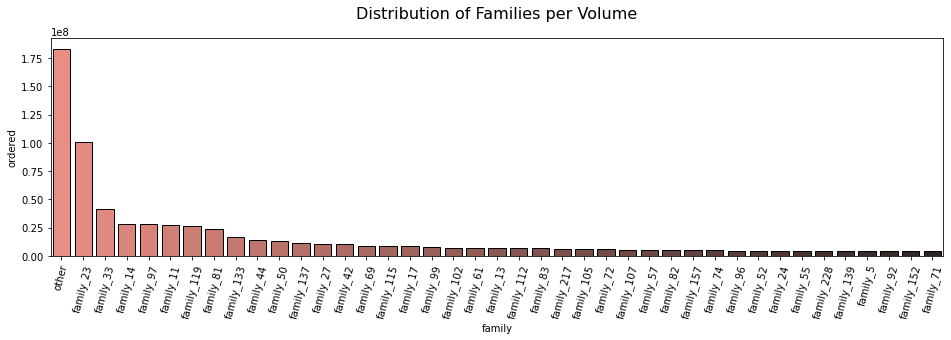

In [321]:
plt.figure(figsize=(16,4))
plt.grid(False)
data = families
plt.xticks(rotation=75)
plt.title('Distribution of Families per Volume',pad=20, fontsize=16)
bar_plot = sns.barplot(x="family", y="ordered", data=data, palette='dark:salmon_r',linewidth=1,edgecolor=".001")

##### Комментарии по семьям:

* Среди семей имеются лидеры, которые покупают фрукты у несколько раз больше остальных семей
* Однозначным лидером по объемам является семья 23
* Лидер среди семей по количеству строк заказов (семья 217) не вошел в 20ку самых больших семей по общему объему
* Объемы сильно разделены между большим количеством семей

##### ***Создание датасетов для каждой семьи***

In [322]:
# Создадим датафреймы для каждой семьи
for parent in df_village.family.unique():
    globals()[f'{parent}'] = df_village.query(f"family == '{parent}'")

In [323]:
# family_119

#### **2.1.3 Category**

In [324]:
# df_village.category.value_counts()

In [325]:
df_village.category.describe()

count          243743
unique            289
top       category_16
freq            30728
Name: category, dtype: object

In [326]:
# # Заменим значения редковстречаемых категорий на other
# df_show = df_village.copy()
# top = df_show['category'].value_counts()[:25].index
# df_show.loc[~df_village['category'].isin(top), 'category'] = 'other'
# df_present = df_show.category.value_counts()
# df_present = pd.DataFrame(df_present)
# df_present = df_present.reset_index()
# df_present.columns = ['category', 'count']

In [327]:
df_cat = df_village.copy()
df_cat = df_cat.groupby(['category']).nunique()
df_cat = df_cat[['fruit','ordered']]
df_cat = df_cat.reset_index()

df_cat = df_cat.sort_values(by='ordered', ascending=False)
cat_order_num = df_cat.head(26)
df_cat = df_cat.sort_values(by='fruit', ascending=False)
cat_fruit_num = df_cat.head(25)

In [328]:
cat_fruit_num.fruit.describe()

count     25.00000
mean      93.40000
std       48.52319
min       45.00000
25%       63.00000
50%       79.00000
75%      115.00000
max      259.00000
Name: fruit, dtype: float64

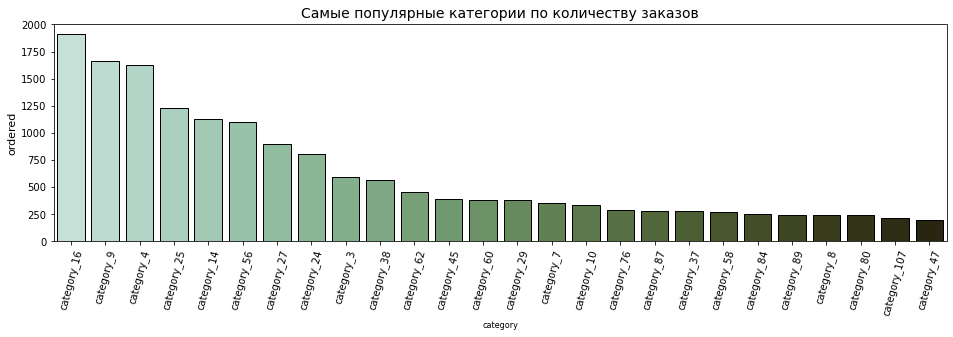

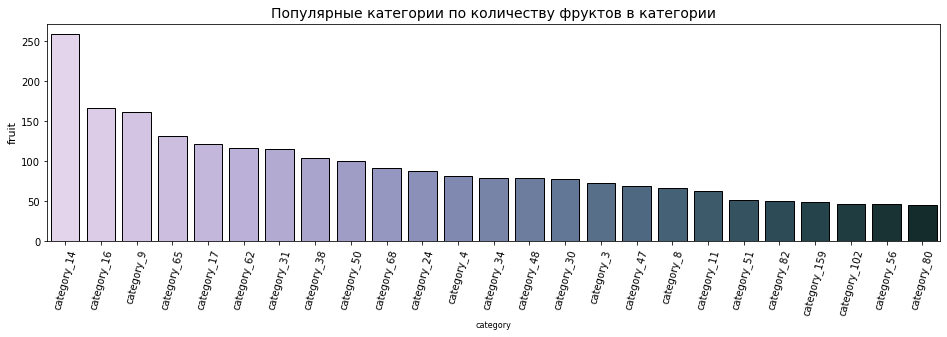

In [329]:
plt.figure(figsize=(16,4))
plt.grid(False)
plt.xlabel('Categories', fontsize=8)
plt.ylabel('Frequency', fontsize=11)
plt.xticks(rotation=75)
plt.title('Самые популярные категории по количеству заказов',fontsize=14)
bar_plot = sns.barplot(data=cat_order_num, x='category', y='ordered', palette='ch:1.25',linewidth=1,edgecolor=".001")
plt.show()

plt.figure(figsize=(16,4))
plt.grid(False)
plt.xlabel('Categories', fontsize=8)
plt.ylabel('Frequency', fontsize=11)
plt.xticks(rotation=75)
plt.title('Популярные категории по количеству фруктов в категории',fontsize=14)
bar_plot = sns.barplot(data=cat_fruit_num, x='category', y='fruit', palette='ch:2.25',linewidth=1,edgecolor=".001")
plt.show()

##### Комментарии по категориям
* Объемы покупок сильно разбиты на различные категории фруктов
* Общее количество категорий: 289
* Можно выделить 3 наиболее популярные категории среди всех семей в деревне:
    * Категория 14
    * Категория 16
    * Категория 9
* Максимальное количество фруктов в одной категории: 259
* Среднее количество фруктов в одной категории: 79

#### **2.1.4 Fruits**

In [330]:
# df_village.fruit.value_counts()

In [331]:
df_village.fruit.describe()

count       243743
unique        4431
top       fruit_19
freq          7912
Name: fruit, dtype: object

In [332]:
fruits_vil = df_village.copy()
fruits_vil = fruits_vil.groupby(['fruit']).sum()
fruits_vil = fruits_vil.sort_values(by='ordered', ascending=False)
fruits_vil = fruits_vil[['ordered','shipped']]
# Заменим значения редковстречаемых категорий на other
fruits_vil.reset_index(inplace=True)
top = 30
fruits_vil.loc[top:,'fruit'] = 'other'
fruits_vil = fruits_vil.groupby(['fruit']).sum()
fruits_vil = fruits_vil.reset_index()
fruits_vil = fruits_vil.sort_values(by='ordered', ascending=False)

In [333]:
# fruits_vil

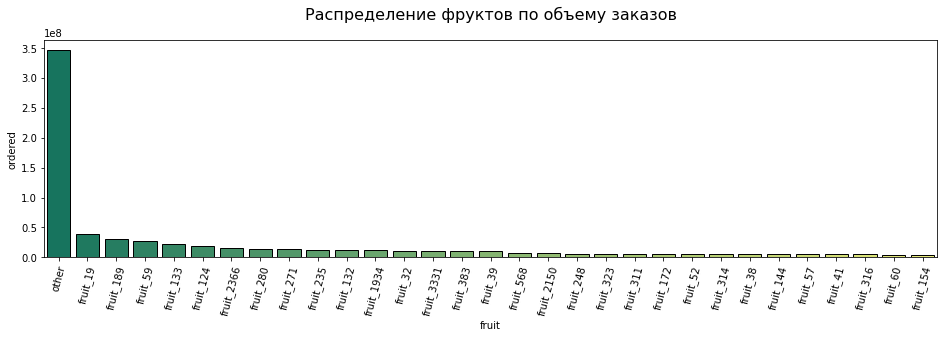

In [334]:
plt.figure(figsize=(16,4))
plt.grid(False)
data = families
plt.xticks(rotation=75)
plt.title('Распределение фруктов по объему заказов',pad=20, fontsize=16)
bar_plot = sns.barplot(x="fruit", y="ordered", data=fruits_vil, palette='summer',linewidth=1,edgecolor=".001")

##### Комментарии по фруктам:
* Более 4 тыс видов фруктов покупают семьи
* Нет явного фаворита среди ассортимента фруктов

#### **2.1.5 Grade**

In [335]:
# df_village['grade'].value_counts()

In [336]:
df_village['grade'].describe()

count    243743.000000
mean        546.081381
std         459.910678
min           0.000000
25%         250.000000
50%         330.000000
75%        1000.000000
max        2000.000000
Name: grade, dtype: float64

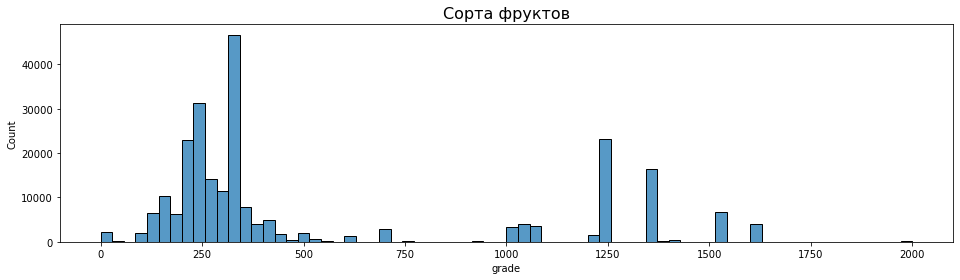

In [337]:
plt.figure(figsize=(16,4))
plt.grid(False)
sns.histplot(df_village['grade'], kde = False, bins=70,linewidth=1,edgecolor=".001")
plt.title('Сорта фруктов',fontsize=16)
plt.show()

##### Комментарии по сортам:
* Сорт фрукта связан с особенностями использования
* Видно некоторое предпочтение семей покупать сорта 200-300
* Есть всплески заинтересованности сортами более 1000, которые требуют дополнительного оборудования для переработки

#### **2.1.6 Количество заказанных фруктов - Ordered**

In [338]:
df_village['ordered'].describe()

count    243743.000000
mean       2814.836876
std        6276.367530
min           0.200000
25%         342.500000
50%        1290.000000
75%        3000.000000
max      492750.000000
Name: ordered, dtype: float64

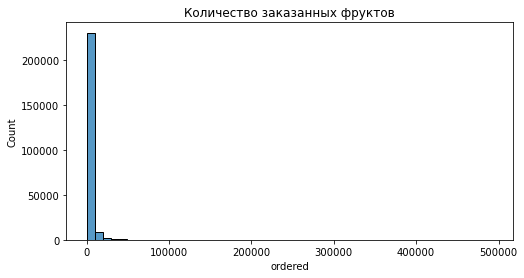

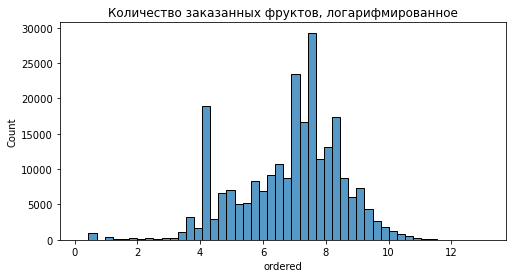

In [339]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(df_village['ordered'], kde = False, bins=50,linewidth=1,edgecolor=".001")
plt.title('Количество заказанных фруктов')
plt.show()

plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(df_village, x=np.log(df_village['ordered']+1), kde = False, bins=50,linewidth=1,edgecolor=".001")
plt.title('Количество заказанных фруктов, логарифмированное')
plt.show()

##### Комментарии по объемам заказов:
* Объемы заказов не распределены нормально
* Большинство заказов - это небольшие заказы
* Это связано с тем, что есть много небольших семей, которые предпочитают делать небольшие заказы
* Есть небольшое количество семей, которые заказывают одноразоао очень много

#### **2.1.7 Частота заказов**

Рассмотреть частоту заказов можно на примере выбранной семьи

In [340]:
days_119 = family_119.copy()
days_119 = days_119[days_119.ordered > 0]
days_119 = days_119.sort_values(by='order_date', ascending=True)
days_119 = days_119[['order_date']]
days_119.drop_duplicates(inplace=True)
# Считаем промежуток между размещением заказов
days_119['difference'] = days_119.order_date.diff()
days_119['difference'] = days_119['difference'].astype('timedelta64[D]')

In [341]:
days_119.difference.describe()

count    440.000000
mean       1.765909
std        1.198793
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        7.000000
Name: difference, dtype: float64

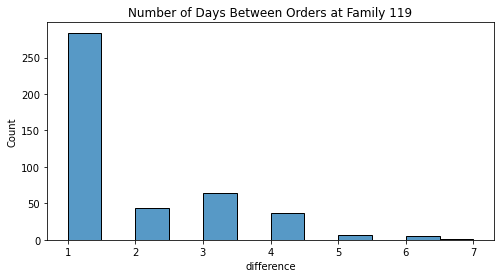

In [342]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(data=days_119, x="difference",linewidth=1,edgecolor=".001", )
plt.title('Number of Days Between Orders at Family 119')
plt.show()

In [343]:
# Как часто семья заказывает не каждый день:
len(difference[difference > '1 days'])

117

Семья 119 не заказывает в выходные, но есть такие, которые заказывают

In [344]:
family_119.order_date.dt.weekday.value_counts()

0    746
1    624
2    597
3    517
4    454
Name: order_date, dtype: int64

In [345]:
family_92.order_date.dt.weekday.value_counts()

5    305
3    257
2    253
4    247
1    237
0    162
6     73
Name: order_date, dtype: int64

Посмотрим, какие семьи заказывают в выходные

In [346]:
weekend = df_village[(df_village.order_date.dt.weekday == 6) | (df_village.order_date.dt.weekday == 5)]
weekend_grouped = weekend.groupby('family').nunique()

In [347]:
weekend_grouped

village  year  category  fruit  grade  order_date  delivery_date  \
family                                                                         
family_0          1     1         1      1      1           1              1   
family_100        1     1         4      8      4           3              7   
family_102        1     1         3      3      2           1              2   
family_108        1     3         5      6      6           3              4   
family_109        1     1         1      1      1           1              1   
...             ...   ...       ...    ...    ...         ...            ...   
family_81         1     1         5      5      5           1              5   
family_88         1     2         3      4     11           6              7   
family_92         1     3        25     56     96          90            160   
family_96         1     2         6      9     13           6              8   
family_97         1     3         2      3      2           3              3   

            ordered  shipped  leadtime  
family                                  
family_0          1        1         1  
family_100        7       11         8  
family_102        4        4         2  
family_108        7        7         3  
family_109        1        1         1  
...             ...      ...       ...  
family_81         4        5         5  
family_88        20       23         4  
family_92       237      346        39  
family_96        16       17         6  
family_97         3        3         3  

[80 rows x 10 columns]

##### Комментарии по частоте заказов:
* Есть разница в том, как семьи делают заказы. Некоторые семьи заказывают только в рабочие дни, некоторые в выходные. Это важный фактор в предсказании закупок
* Большинство клиентов в среднем заказывает каждый день

#### **2.1.8 Объем отгрузок**

In [348]:
df_village['shipped'].describe()

count    243743.000000
mean       2781.541082
std        5789.094096
min           0.147000
25%         342.500000
50%        1292.800000
75%        3007.773000
max      304603.000000
Name: shipped, dtype: float64

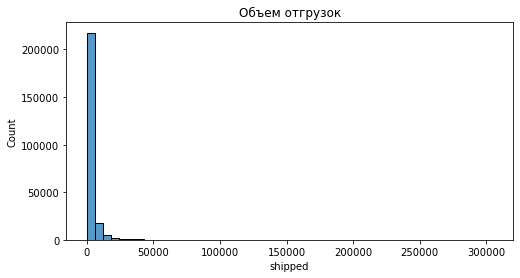

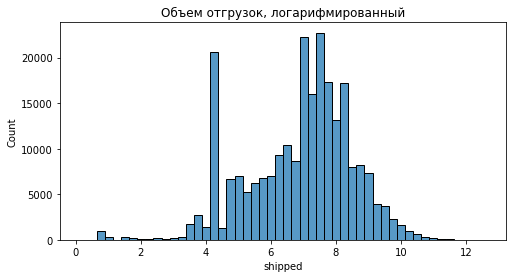

In [349]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(df_village['shipped'], kde = False, bins=50,linewidth=1,edgecolor=".001",)
plt.title('Объем отгрузок')
plt.show()

plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(df_village, x=np.log(df_village['shipped']+1), kde = False, bins=50,linewidth=1,edgecolor=".001",)
plt.title('Объем отгрузок, логарифмированный')
plt.show()

##### Комментарии по отгрузкам:
* Распределение отгрузок похоже на распределение заказов
* Признак отгрузок нужен нам для расчета срока поставки, который может менятся на протяжении времени

#### **2.1.9 Leadtime**

#####  **2.1.9a Per Year**

In [350]:
df_village['leadtime'] = df_village['leadtime'].astype('timedelta64[D]')

In [351]:
# Проверим преобразования
df_village.head()

village  year      family     category     fruit  grade  \
7   Robinhood_village  2020  family_244  category_25  fruit_37    165   
60  Robinhood_village  2020  family_127  category_14  fruit_62    250   
26  Robinhood_village  2020  family_133  category_16  fruit_48    330   
27  Robinhood_village  2020  family_133  category_25  fruit_49    250   
36  Robinhood_village  2020  family_133   category_4  fruit_52    315   

   order_date delivery_date  ordered  shipped  leadtime  
7  2019-12-30    2020-01-03   1650.0  1663.20       4.0  
60 2019-12-30    2020-01-10   1000.0  1060.00      11.0  
26 2019-12-30    2020-01-08   1320.0  1336.50       9.0  
27 2019-12-30    2020-01-08   2500.0  2508.75       9.0  
36 2019-12-30    2020-01-08   4725.0  4759.65       9.0

In [352]:
# За весь период
df_village['leadtime'].describe()

count    243743.000000
mean         13.218275
std          13.704583
min           0.000000
25%           6.000000
50%           8.000000
75%          15.000000
max         401.000000
Name: leadtime, dtype: float64

In [353]:
# В 2020 году
df_village[df_village.year == 2020]['leadtime'].describe()

count    109832.000000
mean         10.344818
std          10.275845
min           0.000000
25%           6.000000
50%           7.000000
75%          12.000000
max         401.000000
Name: leadtime, dtype: float64

In [354]:
# В 2021 году
df_village[df_village.year == 2021]['leadtime'].describe()

count    121965.000000
mean         14.417407
std          14.918086
min           0.000000
25%           6.000000
50%           8.000000
75%          17.000000
max         257.000000
Name: leadtime, dtype: float64

In [355]:
# В 2022 году
df_village[df_village.year == 2022]['leadtime'].describe()

count    11946.000000
mean        27.394191
std         17.252234
min          1.000000
25%          9.000000
50%         28.000000
75%         42.000000
max        129.000000
Name: leadtime, dtype: float64

In [356]:
village_20_21 = df_village[(df_village.delivery_date >= '2020-01-01') & (df_village.delivery_date < '2022-01-01')]

In [357]:
# plt.figure(figsize=(18,6))
# plt.grid(False)
# plt.xlabel('Days', fontsize=11)
# plt.ylabel('Frequency', fontsize=11)
# plt.title('Leadtime 2020 vs 2021 Full Years',fontsize=16)
# sns.histplot(data=village_20_21, x = 'leadtime', hue='year',linewidth=1,edgecolor=".001", kde=True, 
#              kde_kws={'bw_adjust' : 2.4}, bins=300, multiple="dodge", palette='Dark2')
# plt.xlim(0, 40)
# plt.show()

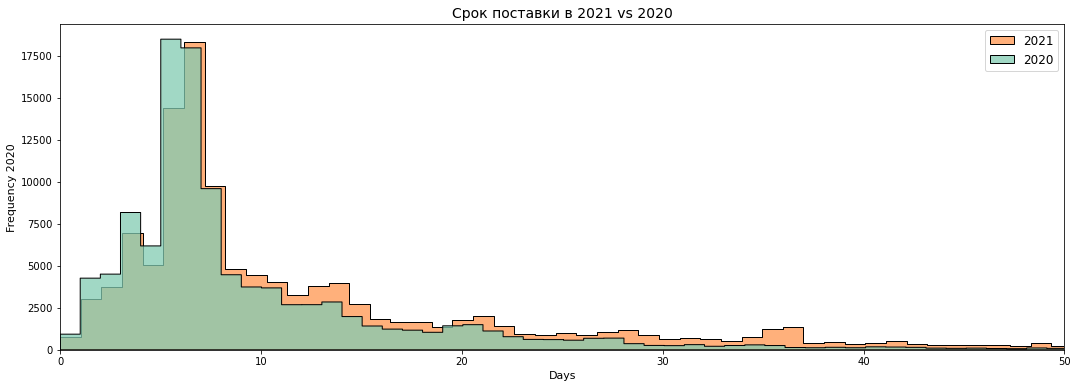

In [358]:
plt.figure(figsize=(18,6))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency 2020', fontsize=11)
plt.title('Срок поставки в 2021 vs 2020',fontsize=14)
sns.histplot(data=df_village[df_village.year == 2021], color = '#ff964f', bins=250, label='2021',element='step',
             x = 'leadtime',linewidth=1, edgecolor=".001",)
sns.histplot(data=df_village[df_village.year == 2020], color = '#82cbb2', bins=400, label='2020',element='step',
             x = 'leadtime',linewidth=1, edgecolor=".001",)
plt.legend(prop={'size': 12})
plt.xlim(0, 50)
plt.show()

2020 и 2021 отдельно

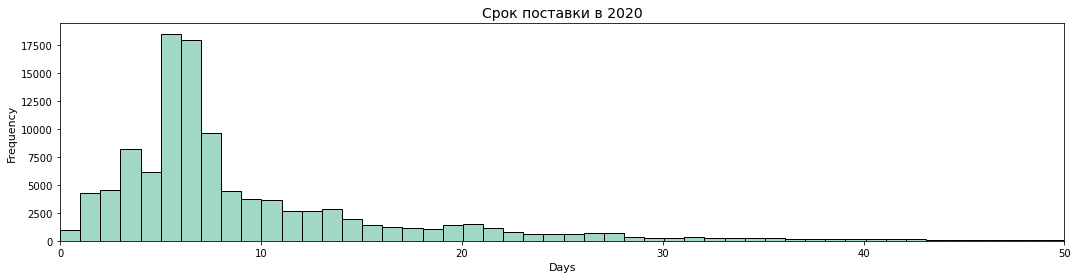

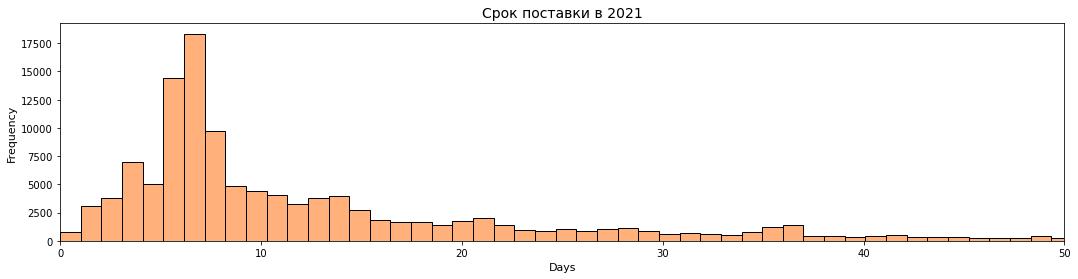

In [359]:
plt.figure(figsize=(18,4))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Срок поставки в 2020',fontsize=14)
sns.histplot(data=df_village[df_village.year == 2020], color = '#82cbb2', bins=400,
             x = 'leadtime',linewidth=1, edgecolor=".001",)
plt.xlim(0, 50)
plt.show()

plt.figure(figsize=(18,4))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Срок поставки в 2021',fontsize=14)
sns.histplot(data=df_village[df_village.year == 2021], color = '#ff964f', bins=250,
             x = 'leadtime',linewidth=1, edgecolor=".001",)
plt.xlim(0, 50)
plt.show()

###### Комментарии по срокам поставки:
* В 2021 видно небольшое смещение сроков поставки в сторону увеличения по сравнению с 2020
* В среднем срок поставки - 10 дней в 2020 и 14 в 2021
* Увеличилась и медиана с 7 до 8 дней
* В 2021 году появляются чаще более длительные сроки, что видно на графике
* Для сравнения с 2022 годом нужно сопоставить соответстующие периоды 2020 и 2021

#####  **2.1.9b Поквартально**

Альтернативный вариант графиков, на которых можно подробнее рассмотреть разницу

In [360]:
# vil_q1_20_22 = df_village[(df_village.delivery_date >= '2020-01-01') & (df_village.delivery_date < '2020-03-01') |\
#                           (df_village.delivery_date >= '2021-01-01') & (df_village.delivery_date < '2021-03-01') |\
#                           (df_village.year == 2022)]
# # village_q1_21 = df_village

In [361]:
# plt.figure(figsize=(18,6))
# plt.grid(False)
# plt.xlabel('Days', fontsize=11)
# plt.ylabel('Count', fontsize=11)
# plt.title('Leadtime in the Beginning of 2020/2021/2020',fontsize=16)
# sns.histplot(data=vil_q1_20_22, x = 'leadtime', hue='year',linewidth=1,edgecolor=".001", kde=True, stat='count',
#              kde_kws={'bw_adjust' : 1}, bins=100, multiple="dodge", palette='Dark2')
# plt.xlim(0, 40)
# plt.show()

In [362]:
village_q1_20 = df_village[(df_village.delivery_date >= '2020-01-01') & (df_village.delivery_date < '2020-03-01')]
village_q1_21 = df_village[(df_village.delivery_date >= '2021-01-01') & (df_village.delivery_date < '2021-03-01')]

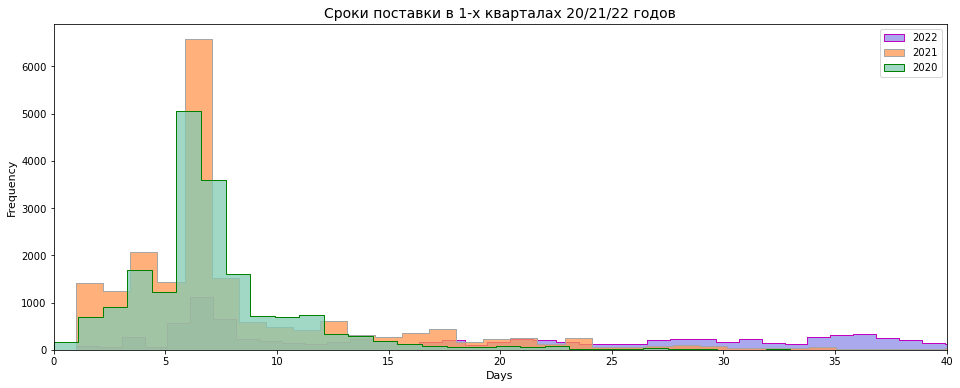

In [363]:
plt.figure(figsize=(16,6))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title("Сроки поставки в 1-х кварталах 20/21/22 годов",fontsize=14)

sns.histplot(data=df_village[df_village.year == 2022], color = '#8f8ce7', bins=125, label = '2022',
             x = 'leadtime',linewidth=1, edgecolor="m",element='step')

sns.histplot(data=village_q1_21, color = '#ff964f', bins=125, label='2021', 
             element='step',
             x = 'leadtime',linewidth=1, edgecolor="0.65",)

sns.histplot(data=village_q1_20, color = '#82cbb2',label = '2020', element='step', bins=40,
             x = 'leadtime',linewidth=1, edgecolor="g",)
plt.legend()
plt.xlim(0, 40)
plt.show()

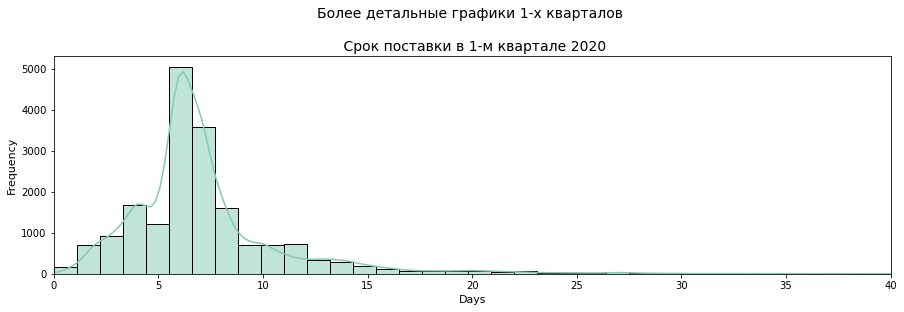

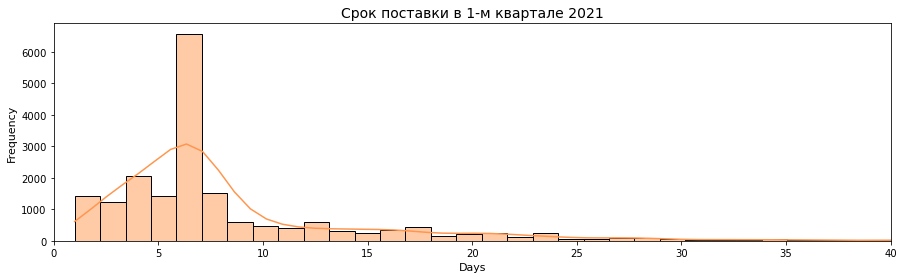

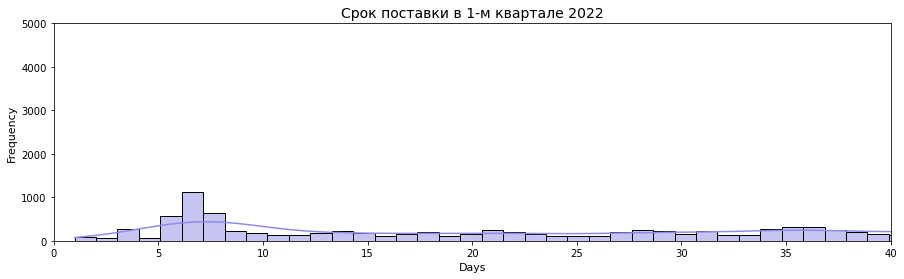

In [364]:
plt.figure(figsize=(15,4))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title("Более детальные графики 1-х кварталов \n \n Срок поставки в 1-м квартале 2020",fontsize=14)
sns.histplot(data=village_q1_20, color = '#82cbb2', bins=40,kde=True,
             x = 'leadtime',linewidth=1, edgecolor=".001",)
plt.xlim(0, 40)
plt.show()

plt.figure(figsize=(15,4))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Срок поставки в 1-м квартале 2021',fontsize=14)
sns.histplot(data=village_q1_21, color = '#ff964f', bins=125, kde=True,
             x = 'leadtime',linewidth=1, edgecolor=".001",)
plt.xlim(0, 40)
plt.show()

plt.figure(figsize=(15,4))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Срок поставки в 1-м квартале 2022',fontsize=14)
sns.histplot(data=df_village[df_village.year == 2022], color = '#8f8ce7', bins=125,kde=True,
             x = 'leadtime',linewidth=1, edgecolor=".001",)
plt.xlim(0, 40)
plt.ylim(0,5000)
plt.show()

###### Комментарии по сроками поставки за кварталы:
* В 2022 явно видно более частое появление длительных (более 30 дней) сроков поставки
* Одновременно есть снижение сроков поставок, которые были "нормой" еще в 2021 году

Более детальное изображение 1 квартала 2020, 2021, 2022

In [365]:
# df_village.head()

In [366]:
# df_village
# df_village.to_csv('village_table.csv', index=False)

### **2.2. Level: Family**

#### **2.2.1 Категории в выбранной семье**

In [367]:
# family_119.category.value_counts()

In [368]:
family_119.category.describe()

count            2938
unique             33
top       category_14
freq              490
Name: category, dtype: object

In [369]:
family_119.head()

village  year      family     category      fruit  grade  \
572  Robinhood_village  2020  family_119   category_3  fruit_310    250   
573  Robinhood_village  2020  family_119   category_3  fruit_310    400   
574  Robinhood_village  2020  family_119   category_9  fruit_311    420   
814  Robinhood_village  2020  family_119  category_76  fruit_382    320   
881  Robinhood_village  2020  family_119  category_24  fruit_406    430   

    order_date delivery_date  ordered  shipped leadtime  
572 2020-01-03    2020-01-13   4000.0   4000.0  10 days  
573 2020-01-03    2020-01-13  24000.0  24500.0  10 days  
574 2020-01-03    2020-01-13  30240.0  30452.1  10 days  
814 2020-01-07    2020-01-16  11520.0  11212.8   9 days  
881 2020-01-07    2020-01-22  20640.0  21156.0  15 days

In [370]:
# df_119_show['category'].value_counts()

In [371]:
df_show = family_119.copy()
df_counts = df_show.category.value_counts()
df_counts = pd.DataFrame(df_counts)
df_counts = df_counts.reset_index()
df_counts.columns = ['category', 'count']
df_volume = family_119.copy()
df_volume = df_volume.groupby(['category']).sum()
df_volume = df_volume[['ordered']]
df_vol_count = pd.merge(df_counts, df_volume, how='left', on='category')

In [372]:
df_vol_count.head()

category  count      ordered
0  category_14    490  2856566.500
1   category_9    449  3856000.000
2  category_38    438  6986985.500
3   category_3    350  2727665.800
4  category_62    212  2214549.544

In [373]:
source = df_vol_count
alt.Chart(source).mark_point().encode(
    x='category',
    y='count',
    size='ordered'
)

alt.Chart(...)

График показывает, какие категории фруктов чаще и больше покупает выбранная семья. Посмотрев на график можно сразу увидеть, какие у семьи предпочтения: какие категрии семья покупает чаще, а какие больше. Редкие категории расположены снизу и имееют небольшие пузырьки

Семья 119 покупает чаще всего категорию 14, а также 91, но по объему они уступают категории 38

In [374]:
# Заменим значения редковстречаемых категорий на other
df_119_show = family_119.copy()
top_1 = 25
top_119 = df_119_show['category'].value_counts()[:top_1].index
df_119_show.loc[~df_village['category'].isin(top_119), 'category'] = 'other'

In [375]:
# test.count = test['count'].apply(lambda x: float(x))

In [376]:
# test_2 = test.copy()
# test_2.category = test_2.category.apply(lambda x: x[9:])
# test_2.category = test_2.category.apply(lambda x: float(x))

In [377]:
# test_2

In [378]:
# test_2.info()

In [379]:
df_pres = df_119_show.category.value_counts()
df_pres = pd.DataFrame(df_pres)
df_pres = df_pres.reset_index()
df_pres.columns = ['category', 'count']

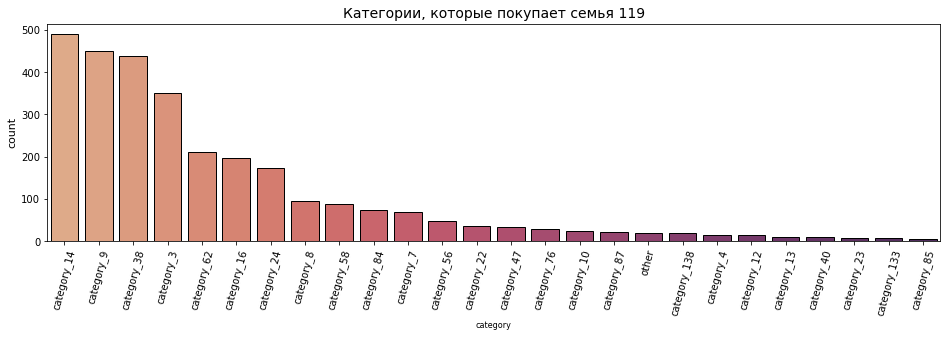

In [380]:
plt.figure(figsize=(16,4))
plt.grid(False)
plt.xlabel('Categories', fontsize=8)
plt.ylabel('Frequency', fontsize=11)
plt.xticks(rotation=75)
plt.title('Категории, которые покупает семья 119',fontsize=14)
bar_plot = sns.barplot(data=df_pres, x='category', y='count', palette='flare',linewidth=1,edgecolor=".001")
plt.show()

In [381]:
df_pres.head()

category  count
0  category_14    490
1   category_9    449
2  category_38    438
3   category_3    350
4  category_62    212

Выведем еще один график распределения категорий в семье 119

In [382]:
categories = family_119.copy()
categories = categories.groupby(['category']).sum()
categories = categories.sort_values(by='ordered', ascending=False)
categories = categories[['ordered','shipped']]

# Заменим значения редковстречаемых категорий на other
categories.reset_index(inplace=True)
top = 10
categories.loc[top:,'category'] = 'other'
categories = categories.groupby(['category']).sum()
categories = categories.sort_values(by='ordered', ascending=False)

In [383]:
# categories.head()

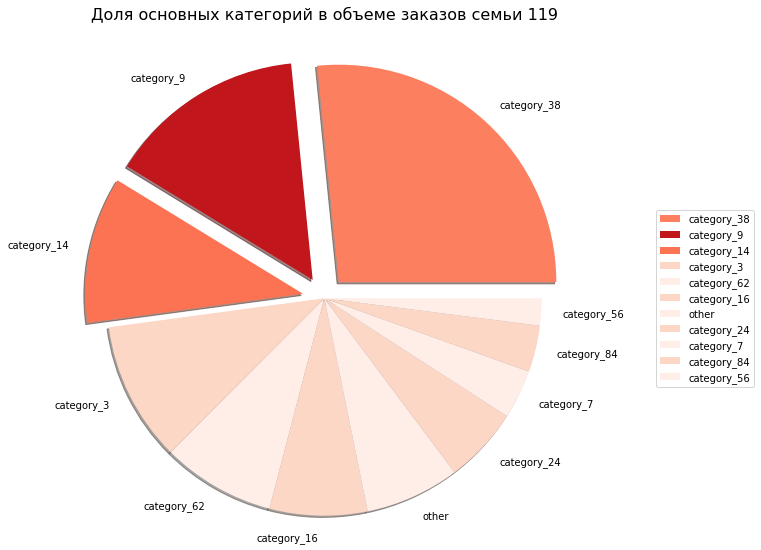

In [384]:
explode = np.zeros(len(categories))
explode[0:3] = 0.25
labels = list(categories.index)
for i in range(len(labels)):
    if i > 15:
        labels[i] = ''

cmap = plt.cm.Reds #Blues, Purples, Green, Reds
plt.pie(categories['ordered'],radius=2.5,
        explode=explode, shadow=True, labels=labels,
        colors = cmap(np.array([110, 200, 120, 40, 10, 40, 10, 40, 10, 40, 10 ]))
        )
       
plt.legend(labels=categories[:30].index, loc="center right",bbox_to_anchor=(2, 0, 0.5, 1))
plt.title('Доля основных категорий в объеме заказов семьи 119', pad=170, fontsize=16)
plt.show()

##### Комментарии по категориям семьи 119:
* Одна семья покупает меньше различных фруктов, но все равно корзина достаточно разнообразна
* Видна заинтересованность 3 категориями, которые составляют более половины всех закупок, остальные отстают в объемах, но в целом являются важным дополнением

#### **2.2.2 Фрукты в выбранной семье**

In [385]:
family_119.fruit.describe()

count         2938
unique         232
top       fruit_32
freq           201
Name: fruit, dtype: object

In [386]:
fruits = family_119.copy()
fruits = fruits.groupby(['fruit']).sum()
fruits = fruits.sort_values(by='ordered', ascending=False)
fruits = fruits[['ordered','shipped']]
# Заменим значения редковстречаемых категорий на other
fruits.reset_index(inplace=True)
top = 30
fruits.loc[top:,'fruit'] = 'other'
fruits = fruits.groupby(['fruit']).sum()
fruits = fruits.reset_index()
fruits = fruits.sort_values(by='ordered', ascending=False)
# fruits = fruits.round(0)

In [387]:
# fruits

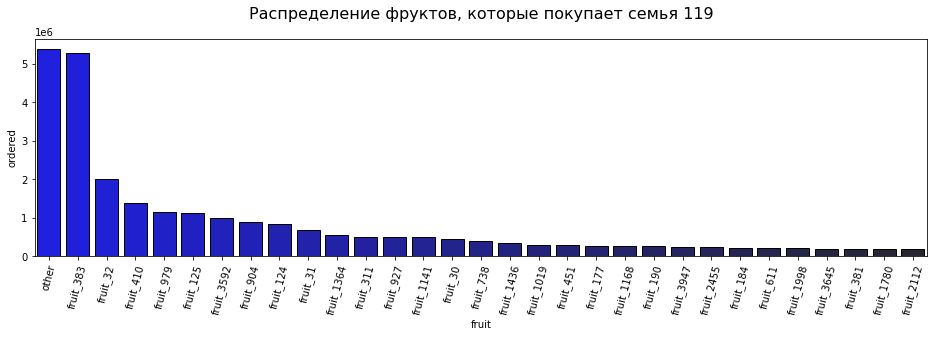

In [388]:
plt.figure(figsize=(16,4))
plt.grid(False)
data = families
plt.xticks(rotation=75)
plt.title('Распределение фруктов, которые покупает семья 119',pad=20, fontsize=16)
bar_plot = sns.barplot(x="fruit", y="ordered", data=fruits, palette='dark:b_r',linewidth=1,edgecolor=".001")

##### Комментарии по фруктам в семье 119
* Есть явный фаворит - фрукт 383
* Фаворит семьи 119 не входит в тор-10 в деревне. Это говорит о некоторой специализации

In [389]:
# Создадим датафреймы с популярным продуктов в семье 119
fruit_32 = family_119.query('fruit == "fruit_32"')
fruit_382 = family_119.query('fruit == "fruit_383"')

In [390]:
# product_382

#### **2.2.3 Сорта в выбранной семье**

In [391]:
# family_119['grade'].value_counts()

In [392]:
family_119['grade'].describe()

count    2938.000000
mean      346.317563
std        47.990049
min         0.000000
25%       333.000000
50%       333.000000
75%       390.000000
max       440.000000
Name: grade, dtype: float64

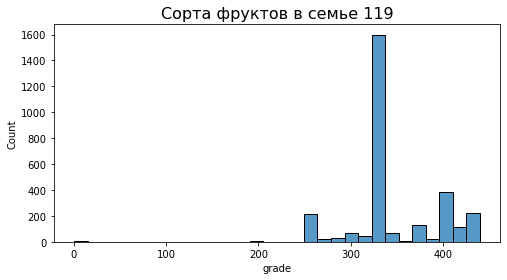

In [393]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(family_119['grade'], kde = False, bins=30,linewidth=1,edgecolor=".001")
plt.title('Сорта фруктов в семье 119',fontsize=16)
plt.show()

##### Комментарии по сортам семьи 119:
* Семья 119 выбирает для себя сорта в диапазоне 300-440
* Это тоже гораздо уже, чем в целом в деревне

#### **2.2.4 .Сорта в выбранной семье и выбранных фруктов**

In [394]:
fruit_32['grade'].describe()

count    201.000000
mean     344.606965
std       48.161808
min      250.000000
25%      300.000000
50%      333.000000
75%      375.000000
max      430.000000
Name: grade, dtype: float64

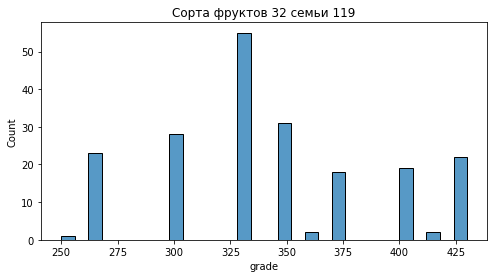

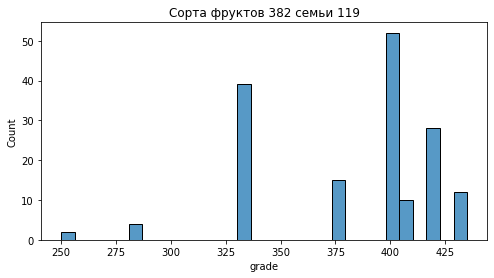

In [395]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(fruit_32['grade'], kde = False, bins=30,linewidth=1,edgecolor=".001")
plt.title('Сорта фруктов 32 семьи 119')
plt.show()

plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(fruit_382['grade'], kde = False, bins=30,linewidth=1,edgecolor=".001")
plt.title('Сорта фруктов 382 семьи 119')
plt.show()

##### Комментарии по сортам выбранных продуктов семьи 119:
* Сорта в выбранных продуктах не сильно отличаются от общего выбора семьи и в иных фруктах

#### **2.2.5 Комбинация фрукт-сорт**

In [396]:
combinations = family_119.copy()
# combinations['grade'] = combinations['grade']*1000
# combinations['grade'] = combinations['grade'].apply(int)
combinations['grade'] = combinations['grade'].apply(str)
combinations['fruit_grade'] = combinations.fruit + ' grade ' + combinations['grade']
combinations = combinations.groupby(['fruit_grade']).sum()
combinations = combinations.sort_values(by='ordered', ascending=False)
combinations = combinations[['ordered','shipped']]

In [397]:
# Заменим значения редковстречаемых категорий на other
comb_show = combinations.copy()
comb_show.reset_index(inplace=True)
top = 40
comb_show.loc[top:,'fruit_grade'] = 'other'
comb_show = comb_show.groupby(['fruit_grade']).sum()
comb_show = comb_show.reset_index()
comb_show = comb_show.sort_values(by='ordered', ascending=False)

In [398]:
# comb_show

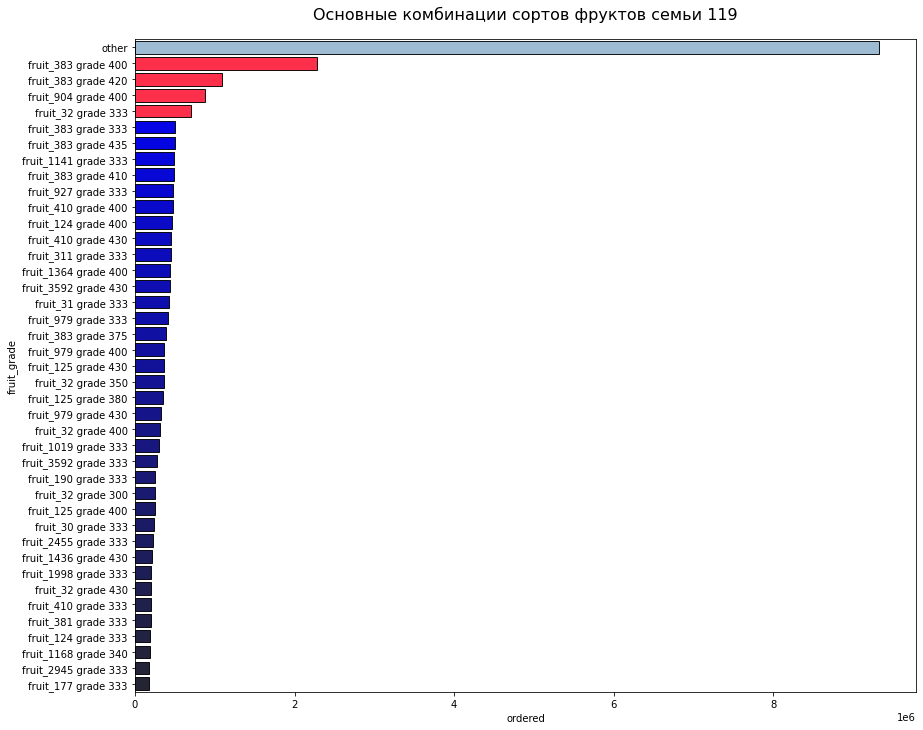

In [399]:
plt.figure(figsize=(14,12))
plt.grid(False)
data = families
plt.xticks(rotation=0)
plt.title('Основные комбинации сортов фруктов семьи 119',pad=20, fontsize=16, )
bar_plot = sns.barplot(y="fruit_grade", x="ordered", data=comb_show, saturation=1, ci='sd',
                       linewidth=0.9,edgecolor=".001",palette='dark:b_r',orient='h',)
bar_plot.patches[0].set_facecolor('#9dbcd4')
bar_plot.patches[1].set_facecolor('#fe2f4a')
bar_plot.patches[2].set_facecolor('#fe2f4a')
bar_plot.patches[3].set_facecolor('#fe2f4a')
bar_plot.patches[4].set_facecolor('#fe2f4a')

##### Комментарии по комбинациям продукт-сорт в семье 119:
* Первые четыре комбинации явно отличаются от остальных
* Фрукт 383 сорт 400 - самый популярный фрукт семьи 119


Стоит обратить внимание на наиболее популярные комбинации под углом предсказания последующих закупок

#### **2.2.6 Количество заказанных фруктов выбранной семьи**

In [400]:
family_119['ordered'].describe()

count      2938.000000
mean       8944.249743
std       12294.700297
min           1.000000
25%        1998.000000
50%        3996.000000
75%        9600.000000
max      104400.000000
Name: ordered, dtype: float64

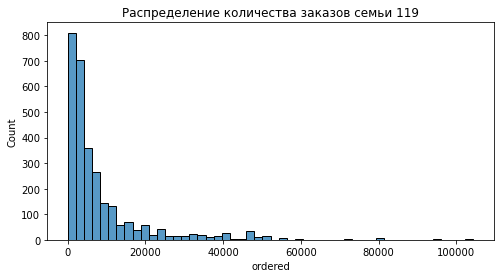

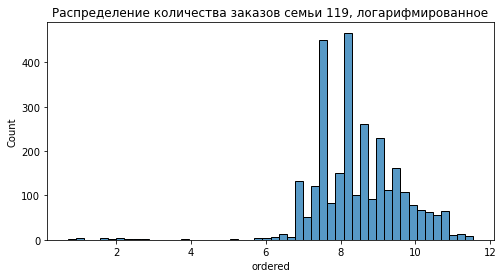

In [401]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(family_119['ordered'], kde = False, bins=50,linewidth=1,edgecolor=".001")
plt.title('Распределение количества заказов семьи 119')
plt.show()

plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(family_119['ordered'],x=np.log(family_119['ordered']+1), kde = False, bins=50,linewidth=1,edgecolor=".001")
plt.title('Распределение количества заказов семьи 119, логарифмированное')
plt.show()

##### Комментарии по заказам семьи 119:
* У семьи 119 тоже есть тенденция делать больше заказов с меньшим размером
* Распределение более нормальное по сравнению с заказами в целом в деревне

Семья 199 не размещает заказы в выходные, но есть семьи, которые размещают заказы в выходные.

#### **2.2.7 Огрузки выбранной семьи**

In [402]:
family_119['shipped'].describe()

count     2938.000000
mean      8694.309633
std      11231.765339
min          0.935000
25%       2138.895000
50%       4286.542500
75%       9498.712500
max      97836.000000
Name: shipped, dtype: float64

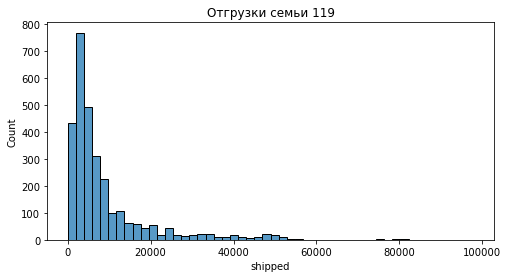

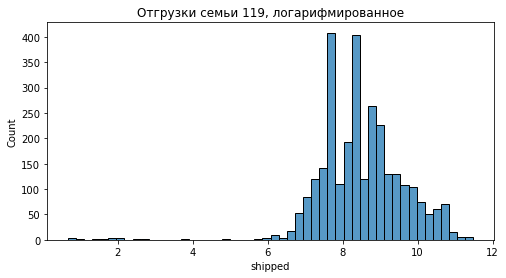

In [403]:
plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(family_119['shipped'], kde = False, bins=50,linewidth=1,edgecolor=".001",)
plt.title('Отгрузки семьи 119')
plt.show()

plt.figure(figsize=(8,4))
plt.grid(False)
sns.histplot(family_119['shipped'],x=np.log(family_119['shipped']+1), kde = False, bins=50,linewidth=1,edgecolor=".001",)
plt.title('Отгрузки семьи 119, логарифмированное')
plt.show()

Объем отгрузок семьи 119 также, как в целом в деревне, не сильно отличается от распределения объема заказов

#### **2.2.8 Срок поставки в выбранной семье**

##### 2.2.8a За год

In [404]:
# За весь период
family_119['leadtime'].describe()

count                          2938
mean     16 days 16:35:27.161334241
std      12 days 00:50:21.945656836
min                 2 days 00:00:00
25%                 8 days 00:00:00
50%                13 days 00:00:00
75%                21 days 00:00:00
max               101 days 00:00:00
Name: leadtime, dtype: object

In [405]:
# В 2020 году
family_119[family_119.year == 2020]['leadtime'].describe()

count                          1185
mean     12 days 01:59:05.316455696
std       7 days 10:48:04.580916684
min                 2 days 00:00:00
25%                 7 days 00:00:00
50%                10 days 00:00:00
75%                14 days 00:00:00
max               101 days 00:00:00
Name: leadtime, dtype: object

In [406]:
# В 2021 году
family_119[family_119.year == 2021]['leadtime'].describe()

count                          1548
mean     17 days 18:34:25.116279069
std      12 days 09:01:40.003568561
min                 3 days 00:00:00
25%                 9 days 00:00:00
50%                14 days 00:00:00
75%                22 days 00:00:00
max                99 days 00:00:00
Name: leadtime, dtype: object

In [407]:
# В 2022 году
family_119[family_119.year == 2022]['leadtime'].describe()

count                           205
mean     35 days 03:44:46.829268292
std      11 days 06:10:06.961138513
min                 3 days 00:00:00
25%                29 days 00:00:00
50%                35 days 00:00:00
75%                43 days 00:00:00
max                60 days 00:00:00
Name: leadtime, dtype: object

In [408]:
family_119['leadtime'] = family_119['leadtime'].astype('timedelta64[D]')

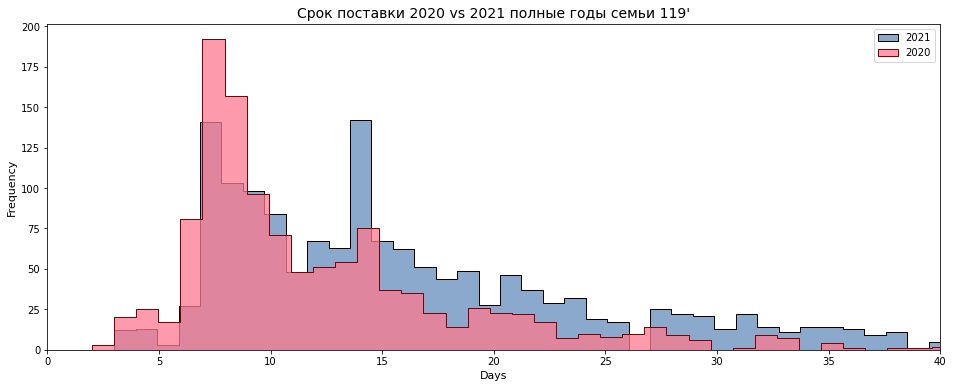

In [409]:
plt.figure(figsize=(16,6))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title("Срок поставки 2020 vs 2021 полные годы семьи 119'",fontsize=14)


sns.histplot(data=family_119[family_119.year == 2021], color = '#658cbb', bins=100,label='2021', 
             element='step',
             x = 'leadtime',linewidth=1, edgecolor="black",)

sns.histplot(data=family_119[family_119.year == 2020], color = '#fd798f',label = '2020', element='step', bins=100,
             x = 'leadtime',linewidth=1, edgecolor="maroon",)
plt.legend()
plt.xlim(0, 40)
plt.show()

###### Комментарии по срокам огтрузки семьи 119:
* Увеличение сроков отгрузки в 2021 по сравнению с 2020 более заметно у семьи 119
* Увеличиваются также минимальные сроки
* Для сравнения сроков в 2022 году необходимо сравнить с соответствующими периодами 2020 и 2021

##### 2.2.8b Квартально

In [410]:
year_20_21 = family_119[(family_119.delivery_date >= '2020-01-01') & (family_119.delivery_date < '2022-01-01')]

In [411]:
# plt.figure(figsize=(18,6))
# plt.grid(False)
# plt.xlabel('Days', fontsize=11)
# plt.ylabel('Frequency', fontsize=11)
# plt.title('Leadtime 2020 vs 2021 Full Years at Family 119',fontsize=16)
# sns.histplot(data=year_20_21, x = 'leadtime', hue='year',linewidth=1,edgecolor=".001", kde=True,
#              multiple="dodge",
#             palette='Set1')
# plt.xlim(0, 60)
# plt.show()

In [412]:
q1_20_119 = family_119[(family_119.delivery_date >= '2020-01-01') & (family_119.delivery_date < '2020-03-01')]
q1_21_119 = family_119[(family_119.delivery_date >= '2021-01-01') & (family_119.delivery_date < '2021-03-01')]
q1_22_119 = family_119[family_119.year == 2022]                       

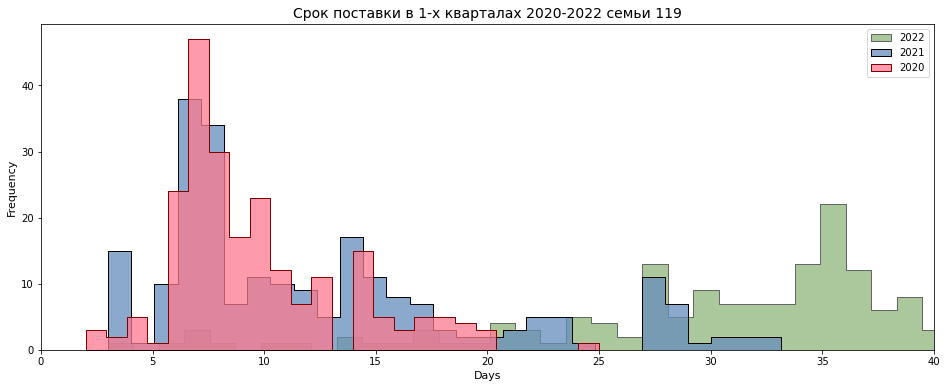

In [413]:
plt.figure(figsize=(16,6))
plt.grid(False)
plt.xlabel('Days', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title("Срок поставки в 1-х кварталах 2020-2022 семьи 119",fontsize=14)

sns.histplot(data=q1_22_119, color = '#8fb67b', bins=50, label = '2022',
             x = 'leadtime',linewidth=1, edgecolor="0.4",element='step')

sns.histplot(data=q1_21_119, color = '#658cbb', bins=50,label='2021', 
             element='step',
             x = 'leadtime',linewidth=1, edgecolor="black",)

sns.histplot(data=q1_20_119, color = '#fd798f',label = '2020', element='step', bins=25,
             x = 'leadtime',linewidth=1, edgecolor="maroon",)
plt.legend()
plt.xlim(0, 40)
plt.show()

###### Комментарии по срокам семьи 119 в 2022:
* Видно сильное увеличение сроков поставки в 2022
* В 2022 году сильно уменьшается количество заказов с небольшим (до 10 дней) сроком реализации и одновремеено растет пик со сроком около 35 дней

#### **2.2.9 Correlations of Numeric Featues**

Проверяем, не осталось ли пропусков для расчета корреляции

In [414]:
# Создаем числовой формат даты заказа
family_119['order_date_int'] = family_119['order_date'].astype('int64') // 10**9

In [415]:
# family_119

In [416]:
num_cols = ['year','grade','ordered','shipped','leadtime','order_date_int']

<AxesSubplot:>

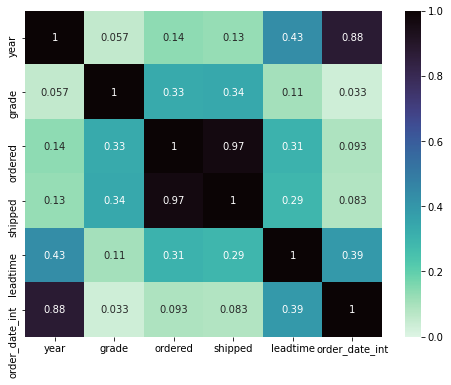

In [417]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(family_119[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, cmap='mako_r')

#####  Комментарии по корреляции:
* Есть сильная корреляция объемов заказа и объемов отгрузки. Это совершенно натурально. Нас будет интересовать объем заказа, а отгрузка интересует, как последствие реализации заказа
* Год отгрузки связан с датой заказа. Год заказа можно использовать, как некоторое обобщение ситуации
* Есть некоторая корреляция между датой заказа и сроком реализации заказа
* Видна корреляция между сроками реализации и годом. Поскольку в разные годы сроки разные
* Есть некоторая корреляция между количеством заказа/огрузки от сорта
* Срок поставки и количество заказа имеют некоторую корреляцию, поскольку срок изменение срока поставки влияет на количество заказа: семья заказываеь больше, когда увеличиваются сроки поставки. Это было видно на графиках

# IV. Преобразование во временной ряд

## **1. Village: Day Level**

### **1.1. Преобразования**

In [418]:
df_village.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243743 entries, 7 to 241554
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   village        243743 non-null  object        
 1   year           243743 non-null  int64         
 2   family         243743 non-null  object        
 3   category       243743 non-null  object        
 4   fruit          243743 non-null  object        
 5   grade          243743 non-null  int64         
 6   order_date     243743 non-null  datetime64[ns]
 7   delivery_date  243743 non-null  datetime64[ns]
 8   ordered        243743 non-null  float64       
 9   shipped        243743 non-null  float64       
 10  leadtime       243743 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 30.4+ MB


In [419]:
# Данные по заказам, которые нужно суммировать
data_village = df_village.copy()
data_village = data_village[['order_date','ordered']]
data_village.columns = ['date','order']
data_village = data_village.sort_values(by='date', ascending=True)
data_village = data_village.groupby(['date']).sum()
data_village_d = data_village.resample('d').sum()

In [420]:
# Данные по отгрузкам, которые нужно суммировать
data_village_s = df_village.copy()
data_village_s = data_village_s[['delivery_date','shipped']]
data_village_s.columns = ['date','shipped']
data_village_s = data_village_s.sort_values(by='date', ascending=True)
data_village_s = data_village_s.groupby(['date']).sum()
data_village_sd = data_village_s.resample('d').sum()

In [421]:
village_day = pd.concat([data_village_d, data_village_sd], axis=1)

In [422]:
# Данные, которые нужно усреднить
data_village_2 = df_village.copy()
data_village_2 = data_village_2[['order_date','leadtime']]
data_village_2.columns = ['date','leadtime']
data_village_2 = data_village_2.sort_values(by='date', ascending=True)
data_village_2 = data_village_2.groupby(['date']).mean()
data_village_2d = data_village_2.resample('d').mean()

In [423]:
village_day = pd.concat([village_day, data_village_2d], axis=1)
village_day.fillna(0, inplace=True)
village_day.columns = ['ordered_village', 'shipped_village', 'leadtime_village']

In [424]:
# Ограничим данные до последнего заказа в датасете
village_day_show = village_day[:'2022-02-20']

In [425]:
# plt.figure(figsize=(30,6))
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Quantity',fontsize=14)
# plt.title('village Orders and Shipment March 2021 - February 2022',fontsize=16)
# plt.plot(village_day_show['ordered_village'][-365:-1], label='Ordered')
# plt.plot(village_day_show['shipped_village'][-365:-1], label='Shipped')
# plt.plot(village_day_show['leadtime_village'][-365:-1]*15000, label='Leadtime')
# plt.legend(loc='upper right')
# plt.show()

# plt.figure(figsize=(30,6))
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Quantity',fontsize=14)
# plt.title('village Orders and Shipment March 2020 - Februay 2021',fontsize=16)
# plt.plot(village_day_show['ordered_village'][-730:-365], label='Ordered')
# plt.plot(village_day_show['shipped_village'][-730:-365], label='Shipped')
# plt.plot(village_day_show['leadtime_village'][-730:-365]*15000, label='Leadtime')
# plt.legend(loc='upper right')
# plt.show()

In [426]:
village_day.index.max()

Timestamp('2022-05-20 00:00:00', freq='D')

### **1.2. График временного ряда**

In [427]:
df = village_day_show.copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index,y=df.ordered_village, name="Orders"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index,y=df.shipped_village, name="Shipment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df.leadtime_village, name="Leadtime"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(title_text="Заказы и огрузки в деревне март 2021 - февраль 2022",
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgba(200,200,200,20)',
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Date<b>",showgrid=False,)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Quantity</b> pcs", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Leadtime</b> days", secondary_y=True, showgrid=False)

fig.show()

 #### Комментарии по графику заказов:
* На графике видно увеличение заказов и сроко реализации в 2022 год
* Видны всплески увеличения сроков реализации в апреле и актябре 2020 года, связанные с волнами пандемии
* После всплеском увеличения заказов видны впадины уменьшения заказов
* Огрузки находятся на подобном уровне, в то время, как закзы подвержены большей волатильности
* Увеличение количества заказов приходит на увеличение сроков поставки

### **1.3. Autocorrelation Analysis**

In [428]:
village_day_ar = village_day_show[['ordered_village']]

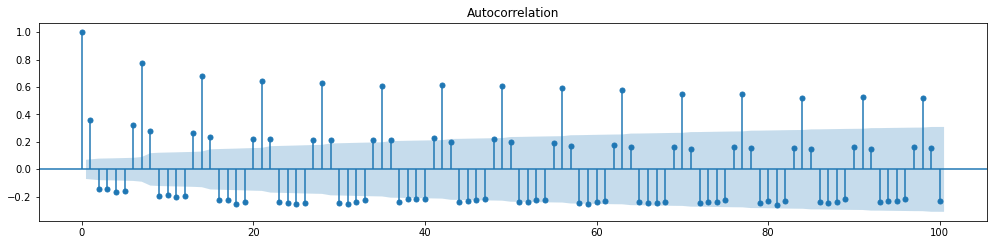

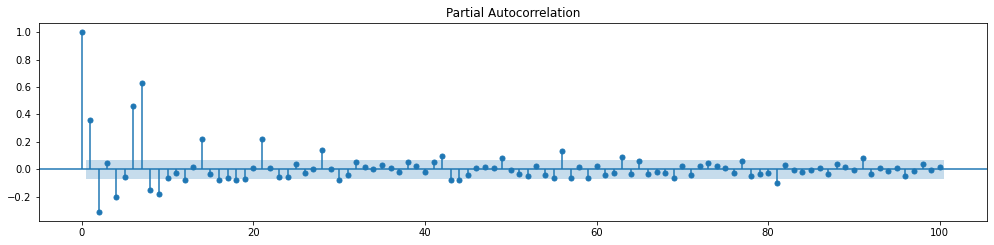

In [429]:
plt.figure(figsize = (17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(village_day_ar.squeeze(), lags=100, ax=ax)
plt.show()

plt.figure(figsize = (17,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(village_day_ar.squeeze(), lags=100, ax=ax)
plt.show()

На графике автокорреляции видна повторяемость заказов (сезонность). Этот график построен на дневной статистике. Нужно взять во внимание, что в выходные семьи или заказывают мало, или вообще не заказывают. Следующим этапом будет аггрегация на уровне недели

Проверим статичность тестом Дики-Фулера:

In [430]:
# тест Дики-Фуллера
stationarity_test(village_day_ar, 30)

p-value:  0.4239523683877136
there is a trend


In [431]:
# тест Дики-Фуллера
stationarity_test(village_day_ar, 100)

p-value:  0.5607703711044147
there is a trend


In [432]:
# тест Дики-Фуллера
stationarity_test(village_day_ar, 200)

p-value:  0.13227038305438016
there is a trend


Тест Дики-Фулера показывает нестационарность (наличие тренда) в промежутке последних 30/100/200 дней.

## **2. Village: Week Level** 

### **2.1. Преобразования**

In [433]:
df_village.order_date.max()

Timestamp('2022-02-20 00:00:00')

In [434]:
df_village.delivery_date.max()

Timestamp('2022-05-20 00:00:00')

In [435]:
# Данные по заказам, которые нужно суммировать
data_village_a = df_village.copy()
data_village_a = data_village_a[['order_date','ordered']]
data_village_a.columns = ['date','order']
data_village_a = data_village_a.sort_values(by='date', ascending=True)
data_village_a = data_village_a.groupby(['date']).sum()
data_village_w = data_village_a.resample('W').sum()

In [436]:
# Данные по отгрузкам, которые нужно суммировать
data_village_b = df_village.copy()
data_village_b = data_village_b[['delivery_date','shipped']]
data_village_b.columns = ['date','shipped']
data_village_b = data_village_b.sort_values(by='date', ascending=True)
data_village_b = data_village_b.groupby(['date']).sum()
data_village_bw = data_village_b.resample('W').sum()

In [437]:
village_week = pd.concat([data_village_w, data_village_bw], axis=1)

In [438]:
# Данные, которые нужно усреднить
data_village_c = df_village.copy()
data_village_c = data_village_c[['order_date','leadtime']]
data_village_c.columns = ['date','leadtime']
data_village_c = data_village_c.sort_values(by='date', ascending=True)
data_village_c = data_village_c.groupby(['date']).mean()
data_village_cw = data_village_c.resample('W').mean()

In [439]:
village_week = pd.concat([village_week, data_village_cw], axis=1)
village_week.fillna(0, inplace=True)
village_week.columns = ['ordered_village', 'shipped_village', 'leadtime_village']

In [440]:
# Ограничим до последнего дня принятого заказа
village_week = village_week[village_week.index <= '2022-02-20']

### **2.2. Timeframe Plot**

In [441]:
df_ = village_week.copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_.index,y=df_.ordered_village, name="Orders"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_.index,y=df_.shipped_village, name="Shipment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_.index, y=df_.leadtime_village, name="Leadtime"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(title_text="Village Orders and Shipments per Weeks in 2020 -2022",
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgba(200,200,200,20)',
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Week<b>",showgrid=False,)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Quantity</b> pcs", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Leadtime</b> days", secondary_y=True, showgrid=False)

fig.show()

#### Комментарии по графику недельных заказов:
* Более отчетливо видны пики увеличения сроков поставки: в апреле 2020, в сентябре 2021, а также в начале 2022
* Падения заказов приходятся на январь, август. Это похоже на сезонность
* Всплески увеличения заказов приходятся на различные периоды. Видимо это связано не с сезонностью, а иными факторами


In [442]:
# plt.figure(figsize=(30,6))
# plt.xlabel('Date', fontsize=14)
# plt.ylabel('Quantity',fontsize=14)
# plt.title('village Orders and Shipment January 2020 - March 2022, per week',fontsize=16)
# plt.plot(village_week['ordered_village'][:-1], label='Ordered')
# plt.plot(village_week['shipped_village'][:-1], label='Shipped')
# plt.plot(village_week['leadtime_village'][:-1], label='Leadtime',color='r',linestyle = '-.')
# plt.legend(loc='upper right')
# plt.show()

### **2.3. Автокорреляция**

In [443]:
village_week

ordered_village  shipped_village  leadtime_village
date                                                          
2020-01-05     1.449655e+06     7.862800e+03          8.883905
2020-01-12     5.004622e+06     1.368152e+06          7.499632
2020-01-19     6.258470e+06     5.209417e+06          7.251593
2020-01-26     6.834442e+06     5.338141e+06          8.182347
2020-02-02     7.272557e+06     5.793297e+06          7.664650
...                     ...              ...               ...
2022-01-23     1.023269e+07     5.912641e+06         27.383759
2022-01-30     9.671470e+06     6.516169e+06         31.700046
2022-02-06     6.578064e+06     6.263542e+06         21.145592
2022-02-13     2.611383e+06     6.776291e+06         18.501390
2022-02-20     1.488049e+06     5.564866e+06         13.854961

[112 rows x 3 columns]

In [444]:
village_week_ar = village_week[['ordered_village']]

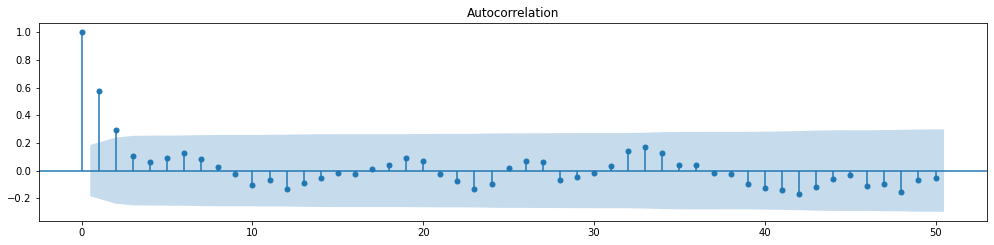

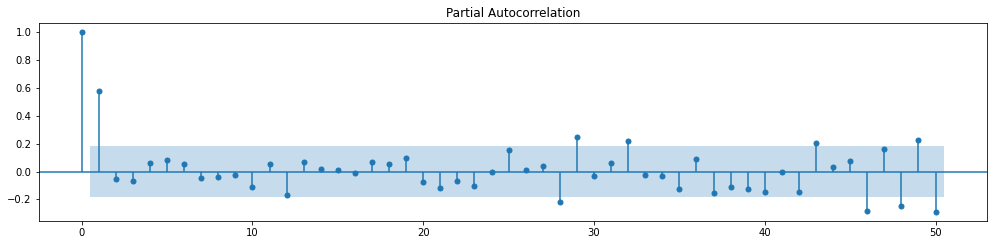

In [445]:
plt.figure(figsize = (17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(village_week_ar.squeeze(), lags=50, ax=ax)
plt.show()

plt.figure(figsize = (17,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(village_week_ar.squeeze(), lags=50, ax=ax)
plt.show()

На графике автокорреляции явно видно, что первые 2 лага существенно отличаются от нуля, а последующие лежат в рамках синей области, то есть их можно с большой уверенностью считать нулями

## **3. Выбранная семья - ежедневно**

### **3.1. Примеры заказов**

In [446]:
data_119 = family_119.copy()
data_119 = data_119.sort_values(by='order_date', ascending=True)

In [447]:
data_119.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2938 entries, 572 to 241535
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   village         2938 non-null   object        
 1   year            2938 non-null   int64         
 2   family          2938 non-null   object        
 3   category        2938 non-null   object        
 4   fruit           2938 non-null   object        
 5   grade           2938 non-null   int64         
 6   order_date      2938 non-null   datetime64[ns]
 7   delivery_date   2938 non-null   datetime64[ns]
 8   ordered         2938 non-null   float64       
 9   shipped         2938 non-null   float64       
 10  leadtime        2938 non-null   float64       
 11  order_date_int  2938 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(3), object(4)
memory usage: 298.4+ KB


Как выглядит заказ семьи 119 в один день:

In [448]:
# Заказ 3 января 2020
data_119.head(3)

village  year      family    category      fruit  grade  \
572  Robinhood_village  2020  family_119  category_3  fruit_310    250   
573  Robinhood_village  2020  family_119  category_3  fruit_310    400   
574  Robinhood_village  2020  family_119  category_9  fruit_311    420   

    order_date delivery_date  ordered  shipped  leadtime  order_date_int  
572 2020-01-03    2020-01-13   4000.0   4000.0      10.0      1578009600  
573 2020-01-03    2020-01-13  24000.0  24500.0      10.0      1578009600  
574 2020-01-03    2020-01-13  30240.0  30452.1      10.0      1578009600

In [449]:
# Заказ 7 января 2020
data_119.iloc[3:18]

village  year      family     category      fruit  grade  \
811  Robinhood_village  2020  family_119  category_16  fruit_190    333   
810  Robinhood_village  2020  family_119  category_58  fruit_381    333   
812  Robinhood_village  2020  family_119   category_9   fruit_59    333   
823  Robinhood_village  2020  family_119  category_38  fruit_125    333   
816  Robinhood_village  2020  family_119  category_38  fruit_383    420   
818  Robinhood_village  2020  family_119  category_14  fruit_384    333   
813  Robinhood_village  2020  family_119   category_9   fruit_59    250   
815  Robinhood_village  2020  family_119  category_38  fruit_383    333   
820  Robinhood_village  2020  family_119   category_9   fruit_32    300   
819  Robinhood_village  2020  family_119   category_9   fruit_32    250   
817  Robinhood_village  2020  family_119  category_38  fruit_383    375   
822  Robinhood_village  2020  family_119  category_14  fruit_385    250   
881  Robinhood_village  2020  family_119  category_24  fruit_406    430   
814  Robinhood_village  2020  family_119  category_76  fruit_382    320   
821  Robinhood_village  2020  family_119   category_9   fruit_32    350   

    order_date delivery_date  ordered    shipped  leadtime  order_date_int  
811 2020-01-07    2020-01-20   3996.0   4005.990      13.0      1578355200  
810 2020-01-07    2020-01-13   2997.0   2942.055       6.0      1578355200  
812 2020-01-07    2020-01-13  11988.0  12187.800       6.0      1578355200  
823 2020-01-07    2020-01-13   3996.0   4009.320       6.0      1578355200  
816 2020-01-07    2020-01-13  59220.0  60039.000       6.0      1578355200  
818 2020-01-07    2020-01-13    999.0    999.000       6.0      1578355200  
813 2020-01-07    2020-01-10   5000.0   5131.250       3.0      1578355200  
815 2020-01-07    2020-01-13   7992.0   8245.080       6.0      1578355200  
820 2020-01-07    2020-01-09   5400.0   5425.200       2.0      1578355200  
819 2020-01-07    2020-01-09   3750.0   3758.000       2.0      1578355200  
817 2020-01-07    2020-01-20  56250.0  56558.250      13.0      1578355200  
822 2020-01-07    2020-01-17   1000.0   1100.000      10.0      1578355200  
881 2020-01-07    2020-01-22  20640.0  21156.000      15.0      1578355200  
814 2020-01-07    2020-01-16  11520.0  11212.800       9.0      1578355200  
821 2020-01-07    2020-01-09  28350.0  28847.700       2.0      1578355200

В один день клиент может делать один или более заказов на раазные продуты, а также разные размеры того же продукта. Каждая комбинация продукт/размер может иметь различный срок реализации

### **3.2. Преобразования**

In [450]:
# Данные по заказам, которые нужно суммировать
data_119 = family_119.copy()
data_119 = data_119[['order_date','ordered']]
data_119.columns = ['date','order']
data_119 = data_119.sort_values(by='date', ascending=True)
data_119 = data_119.groupby(['date']).sum()
data_119_d = data_119.resample('d').sum()

In [451]:
# Данные по отгрузкам, которые нужно суммировать
data_119_s = family_119.copy()
data_119_s = data_119_s[['delivery_date','shipped']]
data_119_s.columns = ['date','shipped']
data_119_s = data_119_s.sort_values(by='date', ascending=True)
data_119_s = data_119_s.groupby(['date']).sum()
data_119_sd = data_119_s.resample('d').sum()

In [452]:
target_day = pd.concat([data_119_d, data_119_sd], axis=1)

In [453]:
# Данные, которые нужно усреднить
data_119_2 = family_119.copy()
data_119_2 = data_119_2[['order_date','leadtime']]
data_119_2.columns = ['date','leadtime']
data_119_2 = data_119_2.sort_values(by='date', ascending=True)
data_119_2 = data_119_2.groupby(['date']).mean()
data_119_2d = data_119_2.resample('d').mean()

In [454]:
target_day = pd.concat([target_day, data_119_2d], axis=1)
target_day.fillna(0, inplace=True)
target_day.columns = ['ordered_family', 'shipped_family', 'leadtime_family']

In [455]:
# Ограничим датасет для графика до последнего дня заказов
target_day_show = target_day[:'2022-02-20']

### **3.3. График временного ряда**

In [456]:
df__ = target_day_show.copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df__.index,y=df__.ordered_family, name="Orders"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df__.index,y=df__.shipped_family, name="Shipment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df__.index, y=df__.leadtime_family, name="Leadtime"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(title_text="Family 119 Orders and Shipments in 2020 -2022",
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgba(200,200,200,20)',
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Week<b>",showgrid=False,)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Quantity</b> pcs", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Leadtime</b> days", secondary_y=True, showgrid=False)

fig.show()

#### Комментарии по графику заказов семьи 119:
* Виден всплеск заказов в январе 2022 года
* Аплитуда огруженных фруктов не такая большая, как амплитуда заказов
* До 2022 года были пики увеличения сроков реализации заказов, но в 2022 году видно кардинальное изменение. Это уже сплошной слой, а не только редкие всплески больших сроков

### **3.4. Autocorrelation and Stationarity**

In [457]:
target_day_ar = target_day[['ordered_family']]

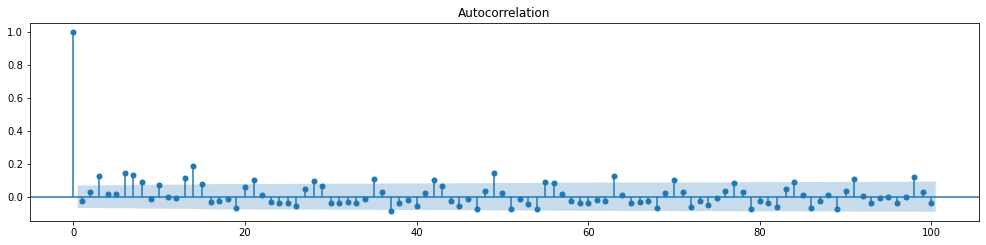

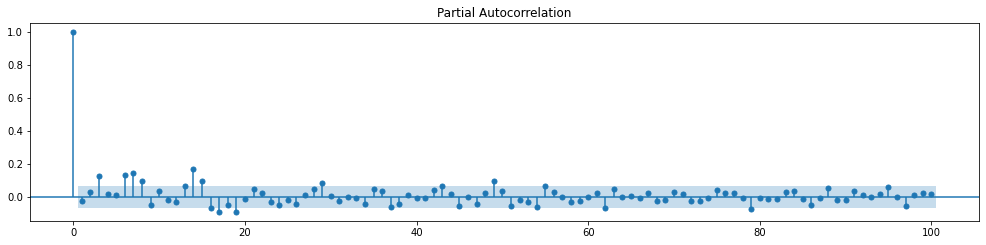

In [458]:
plt.figure(figsize = (17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(target_day_ar.squeeze(), lags=100, ax=ax)
plt.show()

plt.figure(figsize = (17,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(target_day_ar.squeeze(), lags=100, ax=ax)
plt.show()

#### Комментарии по графикам автокорреляции:
* Не видно зависимости от предыдущего заказа

In [459]:
# тест Дики-Фуллера
stationarity_test(target_day_ar, 100)

p-value:  0.0094974005286639
data is stationary


In [460]:
# тест Дики-Фуллера
stationarity_test(target_day_ar, 200)

p-value:  2.997426297882024e-07
data is stationary


Тест Дики-Фулера показывает стационарность в промежутке последних 100/200 дней.

<Figure size 1224x576 with 0 Axes>

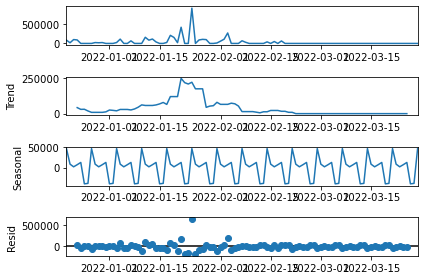

p-value:  0.0094974005286639
data is stationary


In [461]:
visualize_trend(target_day_ar, 7, 100)

<Figure size 1224x576 with 0 Axes>

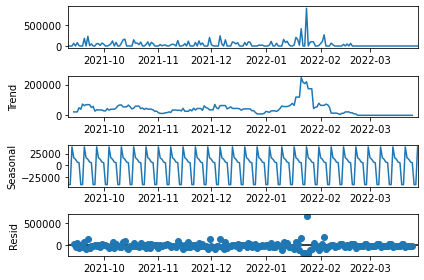

p-value:  2.997426297882024e-07
data is stationary


In [462]:
visualize_trend(target_day_ar, 7, 200)

В долгосрочной перспективе данные стационарны. Были всплески, но не повлияли на результат в целом

### **3.5. Частота заказов семьи 119**

In [463]:
days_119 = family_119.copy()
days_119 = days_119.sort_values(by='order_date', ascending=True)
days_119 = days_119[['order_date']]
days_119.drop_duplicates(inplace=True)
# Считаем промежуток между размещением заказов на выбранный продукт
difference = days_119.order_date.diff()

In [464]:
# difference

In [465]:
difference.describe()

count                          440
mean     1 days 18:22:54.545454545
std      1 days 04:46:15.689917731
min                1 days 00:00:00
25%                1 days 00:00:00
50%                1 days 00:00:00
75%                3 days 00:00:00
max                7 days 00:00:00
Name: order_date, dtype: object

<AxesSubplot:ylabel='Frequency'>

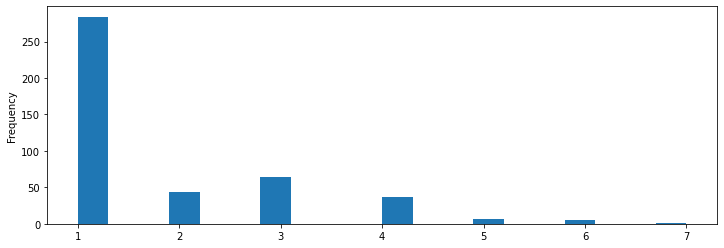

In [466]:
difference.astype('timedelta64[D]').plot.hist(bins=20, figsize=(12, 4), align='mid')

#### Комментарии по графику частоты заказов:
* Семья в основном заказывает каждый день
* Эта семья не размещает заказы в выходные, поэтому некоторые заказы размещаются через 3-4 дня
* Есть случаи, когда заказы размещаются раз в неделю

## **4. Fruit / Family - Daily Level** 

### **4.1. Преобразования**

In [467]:
data_32 = fruit_32.copy()
data_32 = data_32.sort_values(by='order_date', ascending=True)

In [468]:
# Данные по заказам, которые нужно суммировать
data_32_o = data_32[['order_date','ordered']]
data_32_o.columns = ['date','order']
data_32_o = data_32_o.sort_values(by='date', ascending=True)
data_32_o = data_32_o.groupby(['date']).sum()
data_32_od = data_32_o.resample('d').sum()

In [469]:
# Данные по отгрузкам, которые нужно суммировать
data_32_s = data_32[['delivery_date','shipped']]
data_32_s.columns = ['date','shipped']
data_32_s = data_32_s.sort_values(by='date', ascending=True)
data_32_s = data_32_s.groupby(['date']).sum()
data_32_sd = data_32_s.resample('d').sum()

In [470]:
fruit_day = pd.concat([data_32_od, data_32_sd], axis=1)

In [471]:
# Данные, которые нужно усреднить
data_32_l = data_32.copy()
data_32_l = data_32_l[['order_date','leadtime']]
data_32_l.columns = ['date','leadtime']
data_32_l = data_32_l.sort_values(by='date', ascending=True)
data_32_l['leadtime'] = data_32_l['leadtime'].astype(int)
data_32_l = data_32_l.groupby(['date']).mean()
data_32_ld = data_32_l.resample('d').mean()

In [472]:
fruit_day = pd.concat([fruit_day, data_119_2d], axis=1)
fruit_day.fillna(0, inplace=True)
fruit_day.columns = ['ordered_fruit_32', 'shipped_fruit_32', 'leadtime_fruit_32']

In [473]:
fruit_day.index.max()

Timestamp('2022-03-14 00:00:00', freq='D')

In [474]:
# Ограничим датасет для графика до последнего дня заказов
fruit_day_show = fruit_day[:'2022-02-20']

### **4.2. График временного ряда**

In [475]:
df___ = target_day_show.copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df___.index,y=df___.ordered_family, name="Orders"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df___.index,y=df___.shipped_family, name="Shipment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df___.index, y=df___.leadtime_family, name="Leadtime"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(title_text="Orders and Shipments of Fruit 32 by Family 119 in 2020 -2022",
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgba(200,200,200,20)',
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Week<b>",showgrid=False,)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Quantity</b> pcs", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Leadtime</b> days", secondary_y=True, showgrid=False)

fig.show()

#### Комментарии по графику заказов фруктов №32 семьи 119:
* График похож на график заказов семьи в целом
* Виден всплеск заказов в январе 2022 года
* Аплитуда огруженных фруктов не такая большая, как амплитуда заказов
* Сроки реализации похожи на сроки реализации семьи 119 в целом

### **4.3. Частота заказов фрукта №32 семьи 119**

In [476]:
days_32 = fruit_32.copy()
days_32 = days_32.sort_values(by='order_date', ascending=True)
days_32 = days_32[['order_date']]
days_32.drop_duplicates(inplace=True)
# Считаем промежуток между размещением заказов на выбранный продукт
difference = days_32.order_date.diff()

In [477]:
# difference

In [478]:
difference.describe()

count                          136
mean     5 days 12:31:45.882352941
std      6 days 15:05:23.504586534
min                1 days 00:00:00
25%                2 days 00:00:00
50%                4 days 00:00:00
75%                7 days 00:00:00
max               65 days 00:00:00
Name: order_date, dtype: object

<AxesSubplot:ylabel='Frequency'>

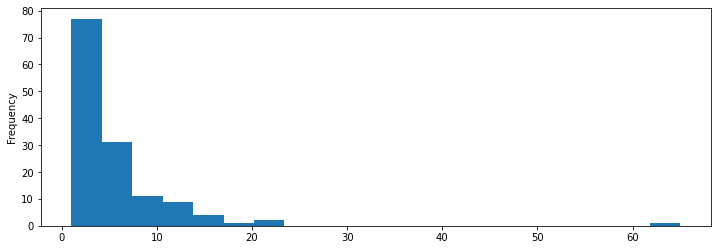

In [479]:
difference.astype('timedelta64[D]').plot.hist(bins=20, figsize=(12, 4), align='mid')

In [480]:
difference[difference > "20 days"]

58533    65 days
101246   21 days
144141   22 days
Name: order_date, dtype: timedelta64[ns]

#### Комментарии по графику частоты заказов фрукта №32:
* Этот фрукт семья заказывает  не всегда каждый день
* Хоть и редко, но есть случаи, когда заказы размещаются после 20 дней

### **4.4. Autocorrelation**

In [481]:
fruit_day_ar = fruit_day[['ordered_fruit_32']]

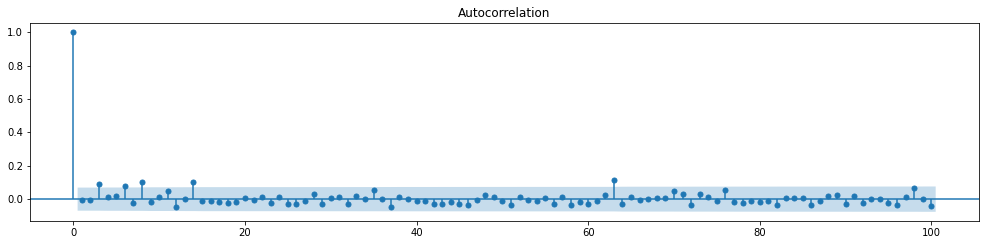

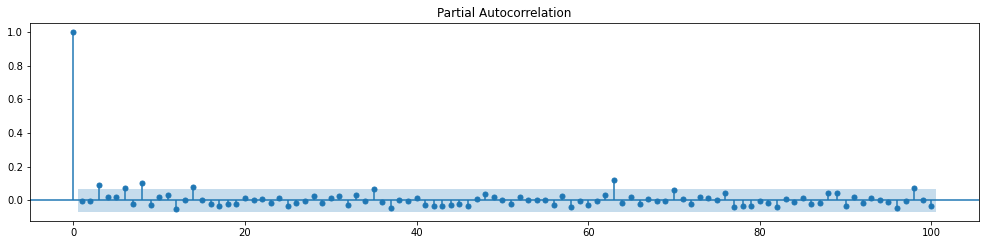

In [482]:
plt.figure(figsize = (17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(fruit_day_ar.squeeze(), lags=100, ax=ax)
plt.show()

plt.figure(figsize = (17,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(fruit_day_ar.squeeze(), lags=100, ax=ax)
plt.show()

График автокорреляции показывает, что данные достаточно хаотичны, нет зависимости от предыдущего заказа. Явной сезонности тоже нет 

<Figure size 1224x576 with 0 Axes>

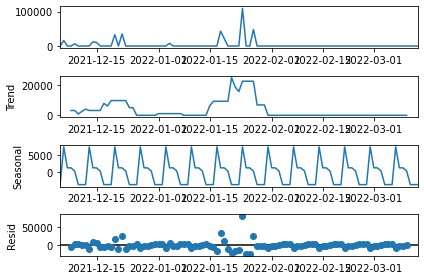

p-value:  0.0003147967510392921
data is stationary


In [483]:
visualize_trend(fruit_day[['ordered_fruit_32']], 7, 100)

<Figure size 1224x576 with 0 Axes>

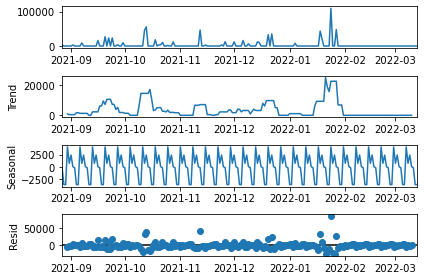

p-value:  5.225955934906478e-25
data is stationary


In [484]:
visualize_trend(fruit_day[['ordered_fruit_32']], 7, 200)

Тест Дики Фулера подтверждает наблюдения по автокорреляции

## **5. Выбранная семья - еженедельно** 

### **5.1. Преобразования**

In [485]:
# Данные по заказам, которые нужно суммировать
data_family_a = family_119.copy()
data_family_a = data_family_a[['order_date','ordered']]
data_family_a.columns = ['date','order']
data_family_a = data_family_a.sort_values(by='date', ascending=True)
data_family_a = data_family_a.groupby(['date']).sum()
data_family_aw = data_family_a.resample('W').sum()

In [486]:
# Данные по отгрузкам, которые нужно суммировать
data_family_b = family_119.copy()
data_family_b = data_family_b[['delivery_date','shipped']]
data_family_b.columns = ['date','shipped']
data_family_b = data_family_b.sort_values(by='date', ascending=True)
data_family_b = data_family_b.groupby(['date']).sum()
data_family_bw = data_family_b.resample('W').sum()

In [487]:
family_week = pd.concat([data_family_aw, data_family_bw], axis=1)

In [488]:
# Данные, которые нужно усреднить
data_family_c = family_119.copy()
data_family_c = data_family_c[['order_date','leadtime']]
data_family_c.columns = ['date','leadtime']
data_family_c = data_family_c.sort_values(by='date', ascending=True)
# data_family_c['leadtime_int'] = data_family_c['leadtime'].dt.days
data_family_c = data_family_c.groupby(['date']).mean()
data_family_cw = data_family_c.resample('W').mean()

In [489]:
family_week = pd.concat([family_week, data_family_cw], axis=1)
family_week.fillna(0, inplace=True)
family_week.columns = ['ordered_family', 'shipped_family', 'leadtime_family']

In [490]:
family_week.index.max()

Timestamp('2022-04-03 00:00:00', freq='W-SUN')

In [491]:
# Ограничим до последнего дня принятого заказа
family_week = family_week[family_week.index <= '2022-02-20']

### **5.2. График временного ряда**

In [492]:
df____ = family_week.copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df____.index,y=df____.ordered_family, name="Orders"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df____.index,y=df____.shipped_family, name="Shipment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df____.index, y=df____.leadtime_family, name="Leadtime"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(title_text="Family's Orders and Shipment January 2020 - March 2022, per week",
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgba(200,200,200,20)',
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Week<b>",showgrid=False,)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Quantity</b> pcs", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Leadtime</b> days", secondary_y=True, showgrid=False)

fig.show()

#### Комментарии  по графику заказов семьи 119 по неделям:
* В январе 2022 года видно сильное увеличение заказов. Этому предшествовало падение отгрузок, а также увеличение до рекордного уровня сроков реализации.
* Данные достаточно хаотичны, но можно в них рассмотреть некоторый тренд

### **5.3. Автокорреляция и стационарность**

In [493]:
family_week_ar = family_week[['ordered_family']]

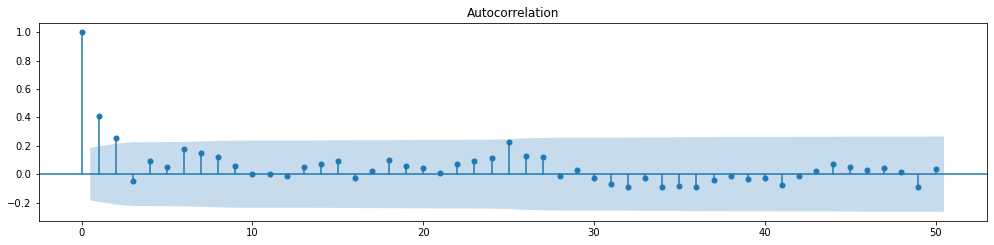

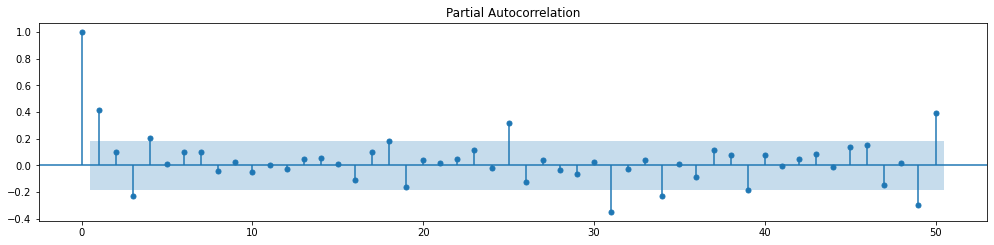

In [494]:
plt.figure(figsize = (17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(family_week_ar.squeeze(), lags=50, ax=ax)
plt.show()

plt.figure(figsize = (17,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(family_week_ar.squeeze(), lags=50, ax=ax)
plt.show()

На графике автокорреляции явно видно, что первый лаг существенно отличается от нуля, а последующие лежат в рамках синей области, то есть их можно с большой уверенностью считать нулями

In [495]:
# тест Дики-Фуллера
stationarity_test(family_week_ar, 200)

p-value:  0.008426075362256659
data is stationary


In [496]:
# тест Дики-Фуллера
stationarity_test(family_week_ar, 100)

p-value:  0.6397363792433508
there is a trend


Тест Дики-Фулера показывает стационарность в промежутке последних 200 дней. Более коротки период говорит о тренде.

<Figure size 1224x576 with 0 Axes>

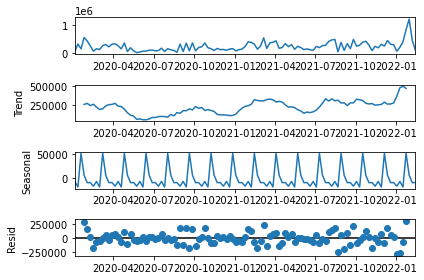

p-value:  0.008426075362256659
data is stationary


In [497]:
visualize_trend(family_week_ar, 7, 200)

<Figure size 1224x576 with 0 Axes>

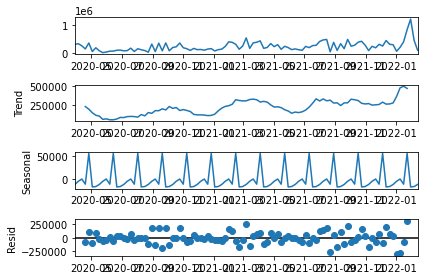

p-value:  0.6397363792433508
there is a trend


In [498]:
visualize_trend(family_week_ar, 7, 100)

В долгосрочной перспективе (200 дней) данные стационарны. Были всплески, но не повлияли на результат в целом. Но уже в промежутке 100 дней виден тренд

## **6. Выбранный фрукт - еженедельно** 

### **6.1. Преобразования**

In [499]:
# Данные по заказам, которые нужно суммировать
data_fruit_a = fruit_32.copy()
data_fruit_a = data_fruit_a[['order_date','ordered']]
data_fruit_a.columns = ['date','order']
data_fruit_a = data_fruit_a.sort_values(by='date', ascending=True)
data_fruit_a = data_fruit_a.groupby(['date']).sum()
data_fruit_aw = data_fruit_a.resample('W').sum()

In [500]:
# Данные по отгрузкам, которые нужно суммировать
data_fruit_b = fruit_32.copy()
data_fruit_b = data_fruit_b[['delivery_date','shipped']]
data_fruit_b.columns = ['date','shipped']
data_fruit_b = data_fruit_b.sort_values(by='date', ascending=True)
data_fruit_b = data_fruit_b.groupby(['date']).sum()
data_fruit_bw = data_fruit_b.resample('W').sum()

In [501]:
fruit_week = pd.concat([data_fruit_aw, data_fruit_bw], axis=1)

In [502]:
# Данные, которые нужно усреднить
data_fruit_c = fruit_32.copy()
data_fruit_c = data_fruit_c[['order_date','leadtime']]
data_fruit_c.columns = ['date','leadtime']
data_fruit_c = data_fruit_c.sort_values(by='date', ascending=True)
data_fruit_c['leadtime_int'] = data_fruit_c['leadtime'].dt.days
data_fruit_c = data_fruit_c.groupby(['date']).mean()
data_fruit_cw = data_fruit_c.resample('W').mean()

In [503]:
fruit_week = pd.concat([fruit_week, data_fruit_cw], axis=1)
fruit_week.fillna(0, inplace=True)
fruit_week.columns = ['ordered_fruit_32', 'shipped_fruit_32', 'leadtime_fruit_32']

In [504]:
fruit_week.index.max()

Timestamp('2022-03-20 00:00:00', freq='W-SUN')

In [505]:
# Ограничим до последнего дня принятого заказа
fruit_week = fruit_week[fruit_week.index <= '2022-02-20']

### **6.2. График временного ряда**

In [506]:
df_____ = fruit_week.copy()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_____.index,y=df_____.ordered_fruit_32, name="Orders"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_____.index,y=df_____.shipped_fruit_32, name="Shipment"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_____.index, y=df_____.leadtime_fruit_32, name="Leadtime"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(title_text="Orders and Shipment of fruit #32 January 2020 - March 2022, per week",
                  paper_bgcolor='rgb(233,233,233)',
                  plot_bgcolor='rgba(200,200,200,20)',
)

# Set x-axis title
fig.update_xaxes(title_text="<b>Week<b>",showgrid=False,)


# Set y-axes titles
fig.update_yaxes(title_text="<b>Quantity</b> pcs", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Leadtime</b> days", secondary_y=True, showgrid=False)

fig.show()

#### Комментарии  по графику заказов фрукта 32 семьи 119 по неделям:
* Видны пики в заказах. Это по всей видимости является определенным паттерном заказов фрукта 32 в рассматриваемом периоде. 
* Наблюдается увеличение заказов в начале 2022, но такие всплески периодически происходят при заказах этого фрукта. 
* Данные достаточно хаотичны

### **6.3. Автокорреляция и стационарность**

In [507]:
fruit_week_ar = fruit_week[['ordered_fruit_32']]

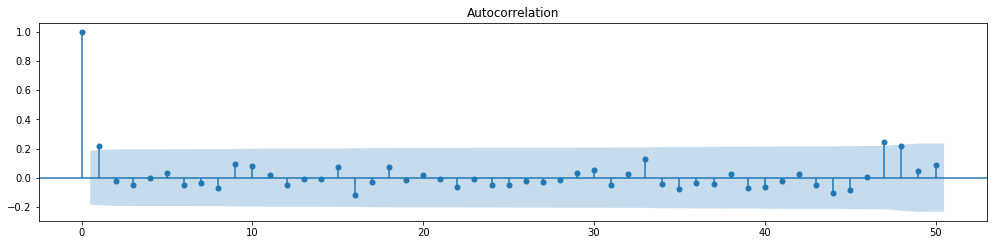

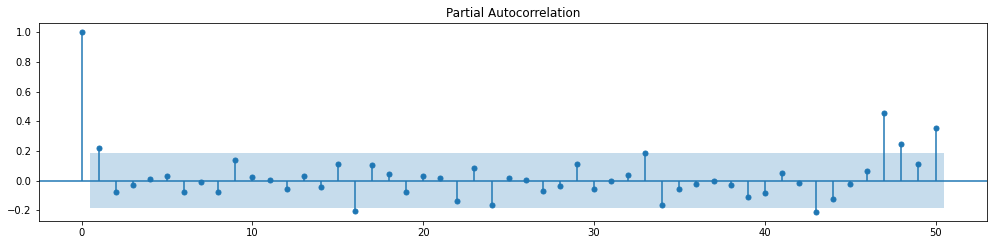

In [508]:
plt.figure(figsize = (17,8))
ax = plt.subplot(211)
# tsa.plot_acf рисует коррелограмму acf. lags=100 задает число лагов, для которых строится acf
sm.graphics.tsa.plot_acf(fruit_week_ar.squeeze(), lags=50, ax=ax)
plt.show()

plt.figure(figsize = (17,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(fruit_week_ar.squeeze(), lags=50, ax=ax)
plt.show()

На графике автокорреляции явно видно, что первый 1 лаг слегка отличается от нуля, а последующие лежат в рамках синей области, то есть их можно с большой уверенностью считать нулями